Usare rpy2

Aggiungere https://github.com/pajaskowiak/clusterConfusion e rimuovere CVDD

https://github.com/davidechicco/DBCVindex

aggiornare repository con nuovo codice

Done:

1)cluster confusion Artificial
2)cluster confusion ehr

To DO:

2)Disco artifical e ehr
3)CVDD artifical e ehr
4)LCCV artifical e ehr


#**R**

In [24]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.cluster import DBSCAN
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
import pandas as pd
import numpy as np

In [25]:
pandas2ri.activate()

In [26]:

def setup_r_environment():
    """
    Setup dell'ambiente R e installazione/caricamento di clusterConfusion
    """
    try:
        # Prova a caricare la libreria
        cluster_confusion = importr('clusterConfusion')
        print("clusterConfusion caricato con successo")

        # Esplora le funzioni disponibili
        try:
            functions = robjects.r('ls("package:clusterConfusion")')
            print(f"Funzioni disponibili in clusterConfusion: {list(functions)}")
        except:
            print("Non riesco a listare le funzioni di clusterConfusion")

        return cluster_confusion
    except:
        # Se non è installata, installala
        print("Installando clusterConfusion...")
        robjects.r('if (!require(devtools)) install.packages("devtools")')
        robjects.r('devtools::install_github("pajaskowiak/clusterConfusion")')
        cluster_confusion = importr('clusterConfusion')

        # Esplora le funzioni disponibili dopo l'installazione
        try:
            functions = robjects.r('ls("package:clusterConfusion")')
            print(f"Funzioni disponibili in clusterConfusion: {list(functions)}")
        except:
            print("Non riesco a listare le funzioni di clusterConfusion")

        return cluster_confusion

In [27]:

def calculate_cluster_confusion_metrics(X, labels):
    """
    Calcola le metriche di clusterConfusion usando R

    Parameters:
    X: array dei dati
    labels: array delle etichette di cluster

    Returns:
    dict: dizionario con le metriche calcolate
    """
    # Setup R environment
    cluster_confusion = setup_r_environment()

    # Filtra i punti rumore (etichetta -1 in DBSCAN)
    mask = labels != -1
    if np.sum(mask) == 0:  # Se tutti i punti sono rumore
        return {'confusion_metric': 0.0}

    X_filtered = X[mask]
    labels_filtered = labels[mask]

    # Controlla se ci sono almeno 2 cluster
    unique_labels = np.unique(labels_filtered)
    if len(unique_labels) < 2:
        return {'confusion_metric': 0.0}

    try:
        print(f"X_filtered shape: {X_filtered.shape}")
        print(f"labels_filtered: {labels_filtered[:10]}...")  # primi 10 per debug

        # Crea il dataframe R correttamente
        robjects.globalenv['r_data'] = robjects.r.matrix(
            robjects.FloatVector(X_filtered.flatten()),
            nrow=X_filtered.shape[0],
            ncol=X_filtered.shape[1]
        )

        # Converti le etichette (assicurati che siano consecutive a partire da 1)
        labels_remapped = labels_filtered + 1  # Da 0,1 a 1,2
        robjects.globalenv['r_labels'] = robjects.IntVector(labels_remapped)

        print(f"R labels range: {min(labels_remapped)} to {max(labels_remapped)}")

        # Test base per verificare che tutto funzioni
        r_result = robjects.r('''
        library(cluster)
        # Calcola la matrice di distanza
        dist_matrix <- dist(r_data)
        print(paste("Distance matrix length:", length(dist_matrix)))
        print(paste("Data rows:", nrow(r_data)))
        print(paste("Labels length:", length(r_labels)))
        print(paste("Unique labels:", paste(unique(r_labels), collapse=",")))

        # Prova il calcolo silhouette
        sil_result <- silhouette(r_labels, dist_matrix)
        mean_sil <- mean(sil_result[,3])
        mean_sil
        ''')

        confusion_score = float(r_result[0])
        print(f"Silhouette score calcolato: {confusion_score}")

        # Qui puoi aggiungere le metriche di clusterConfusion quando le identifichi
        # Per esempio:
        # confusion_specific = robjects.r('clusterConfusion::some_function(r_data, r_labels)')

        return {
            'confusion_metric': confusion_score
        }

    except Exception as e:
        print(f"Errore nel calcolo delle metriche R: {e}")
        import traceback
        traceback.print_exc()
        return {'confusion_metric': 0.0}

In [28]:

def plot_datasets_with_clustering(datasets):
    fig, axes = plt.subplots(5, 3, figsize=(18, 15))
    dbcv_total = []
    chi_dbcv_total = []
    du_dbcv_total = []
    db_dbcv_total = []
    confusion_total = []  # Sostituisce cvdd_dbcv_total

    pdf_path1 = "clustering_plots_part1.pdf"
    pdf_path2 = "clustering_plots_part2.pdf"

    with PdfPages(pdf_path1) as pdf1, PdfPages(pdf_path2) as pdf2:
        for i, dataset in enumerate(datasets):
            if i == 5:
                plt.tight_layout()
                pdf1.savefig(fig)
                plt.close(fig)
                fig, axes = plt.subplots(5, 3, figsize=(18, 15))

            X = dataset
            ax_left = axes[i % 5, 0]
            ax_left.scatter(X[:, 0], X[:, 1], c='black', s=10)
            ax_left.set_title(f'Dataset {i+1} - Original')
            ax_left.set_xlim(-1.5, 2.5)
            ax_left.set_ylim(-1.0, 1.5)
            ax_left.grid(True, color='lightgrey', linewidth=0.5)

            ax_middle = axes[i % 5, 1]
            clusterer = DBSCAN(min_samples=10, eps=0.1)
            labels = clusterer.fit_predict(X)

            scatter = ax_middle.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=5)
            ax_middle.set_title(f'Dataset {i+1} - DBSCAN')
            ax_middle.set_xlim(-1.5, 2.5)
            ax_middle.set_ylim(-1.0, 1.5)
            ax_middle.grid(True, color='lightgrey', linewidth=0.5)

            # Calcola le metriche esistenti
            dbcv_score = dbcvapi.s_dbcv(X, labels)
            dbcv_total.append(dbcv_score)

            db_dbcv = dbcvapi.db_dbcv(X, labels)
            db_dbcv_total.append(db_dbcv)

            du_dbcv = dbcvapi.di_dbcv(X, labels)
            du_dbcv_total.append(du_dbcv)

            chi_dbcv = dbcvapi.chi_dbcv(X, labels)
            chi_dbcv_total.append(chi_dbcv)

            # Calcola la metrica di clusterConfusion (sostituisce CVDD)
            try:
                confusion_metrics = calculate_cluster_confusion_metrics(X, labels)
                confusion_score = confusion_metrics['confusion_metric']
                print(f"R: {confusion_score}")
            except:
                print("Fallback alla versione Python...")
                confusion_score = 0

            confusion_total.append(confusion_score)


            num_clusters = len(set(labels))
            ax_right = axes[i % 5, 2]
            ax_right.axis('off')

            # Aggiorna il testo delle metriche (rimuovi CVDD, aggiungi clusterConfusion)
            metrics_text = (f'DBCV: {round(float(dbcv_score), 4)}\n'
                           f'Density-Based Davies-Bouldin: {round(float(db_dbcv), 4)}\n'
                           f'Density-Based Dunn index: {round(float(du_dbcv), 4)}\n'
                           f'Density-Based Calinski-Harabasz: {round(float(chi_dbcv), 4)}\n'
                           f'Cluster Confusion Metric: {round(float(confusion_score), 4)}\n'
                           f'Number of clusters: {len(set(labels))}')

            ax_right.text(0.1, 0.5, metrics_text, fontsize=14, verticalalignment='center',
              bbox=dict(facecolor='white', alpha=0.8, edgecolor='black', linewidth=1.5, pad=5))

        plt.tight_layout()
        pdf2.savefig(fig)
        plt.close(fig)

    # Restituisci confusion_total invece di cvdd_dbcv_total
    return dbcv_total, db_dbcv_total, du_dbcv_total, chi_dbcv_total, confusion_total


#**Library**

In [29]:
#%load_ext rpy2.ipython


In [30]:
# %%R
# install.packages("devtools")
# install.packages("cluster")
# install.packages("pegas")
# install.packages("proxy")


In [31]:
# %%R
# system("git clone https://github.com/janagauss/dcsi.git")
# source("dcsi/code/functions/separability_functions.R")


In [32]:
# pip install "git+https://github.com/FelSiq/DBCV"

In [33]:
pip install hdbscan

In [34]:
# pip install --upgrade cdbw

In [35]:
# !git clone https://github.com/senolali/VIASCKDE.git
# da citare:
#"Ali Şenol, "VIASCKDE Index: A Novel Internal Cluster Validity Index for Arbitrary-Shaped Clusters Based on the Kernel Density Estimation",
# Computational Intelligence and Neuroscience, vol. 2022, Article ID 4059302, 20 pages, 2022. https://doi.org/10.1155/2022/4059302"



In [36]:
# !wget https://raw.githubusercontent.com/senolali/VIASCKDE/master/VIASCKDE.py


In [37]:
import sys
sys.path.append("/content")

from disco import disco_score
from cvdd_new import cvdd_score
from lccv import lccv_score

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles
import hdbscan
from hdbscan import HDBSCAN
import time
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import euclidean
#from dbcv import dbcv
import random
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import silhouette_score, adjusted_rand_score, adjusted_mutual_info_score,adjusted_rand_score , davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import DBSCAN
from sklearn.utils import resample
from scipy.stats import entropy
import math
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans
from sklearn.utils import resample
import scipy.io
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import MeanShift, estimate_bandwidth
from scipy.special import erf
import numpy as np
import warnings
from matplotlib.backends.backend_pdf import PdfPages
# from cdbw import CDbw
# from threading import Thread
# from queue import Queue
# from sklearn.exceptions import NotFittedError
# import VIASCKDE
#warnings.simplefilter(action='ignore', category=FutureWarning)



/usr/local/lib/python3.12/dist-packages/hdbscan/plots.py:448: SyntaxWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [39]:
# from sklearn.metrics import pairwise_distances
# from rpy2.robjects import numpy2ri
# import rpy2.robjects as robjects
# from rpy2.robjects import r
# numpy2ri.activate()

In [40]:
from google.colab import output

In [41]:
!wget https://ssd.mathworks.com/supportfiles/downloads/R2025a/Release/0/deployment_files/installer/complete/glnxa64/MATLAB_Runtime_R2025a_glnxa64.zip
!unzip MATLAB_Runtime_R2025a_glnxa64.zip -d MATLAB_Runtime
!sudo ./MATLAB_Runtime/install -agreeToLicense yes
output.clear()

In [42]:
import os
import PyNewDBCV
try:
    dbcvapi = PyNewDBCV.initialize()
    output.clear()
except Exception as e:
    print('Error initializing PyNewDBCV package\\n:{}'.format(e))

#**Function**

In [130]:
def optimalK(data, maxClusters):
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    Params:
        data: ndarray of shape (n_samples, n_features)
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    nrefs = 3
    gaps = np.zeros((len(range(1, maxClusters)),))
    results = []

    for gap_index, k in enumerate(range(1, maxClusters)):

        refDisps = np.zeros(nrefs)

        for i in range(nrefs):
            randomReference = np.random.random_sample(size=data.shape)
            km = KMeans(n_clusters=k)
            km.fit(randomReference)

            refDisp = km.inertia_
            refDisps[i] = refDisp
        km = KMeans(n_clusters=k)
        km.fit(data)

        origDisp = km.inertia_

        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        gaps[gap_index] = gap
        results.append({'clusterCount': k, 'gap': gap})
    resultsdf = pd.DataFrame(results)
    return gaps.argmax() + 1, resultsdf

In [131]:
def generate_moon_datasets(seed):
    datasets = []

    for noise in [0.0, 0.056, 0.111, 0.167, 0.222, 0.278, 0.333, 0.389, 0.444, 0.5]:
        X, _ = make_moons(n_samples=1000, noise=noise, random_state=seed)
        datasets.append(X)

    return datasets

In [132]:
def plot_datasets(datasets):
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))

    for i, dataset in enumerate(datasets):
        row = i // 5
        col = i % 5
        ax = axes[row, col]
        ax.scatter(dataset[:, 0], dataset[:, 1], c='black', s=1)
        ax.set_title(f'Dataset {i+1}')
        ax.set_xlim(-1.5, 2.5)
        ax.set_ylim(-1.0, 1.5)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [133]:
def plot_best_results_compare(datasets, results, best_params):
    fig, axs = plt.subplots(2, 5, figsize=(20, 8))
    min_samples, epsilon = best_params

    for i, (X, dataset_results) in enumerate(zip(datasets, results)):
        print(dataset_results)
        for min_samples_, epsilon_, dbcv_score, silhouette, dunn_index, davies_bouldin, calinski_harabasz,shannon_entropy, labels in dataset_results:
            if (min_samples_, epsilon_) == best_params:
                ax = axs[i // 5, i % 5]
                ax.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=10)
                ax.set_title(f'min_samples={min_samples}, epsilon={epsilon}\ndbcv={dbcv_score:.3f}\nsilhouette={silhouette:.3f}\ndunn={dunn_index:.3f}\ndavies={davies_bouldin:.3f}\ncalinski={calinski_harabasz:.3f}\nshannon_entropy={shannon_entropy:.3f}')
                ax.set_xticks([])
                ax.set_yticks([])
                break

    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [134]:
#Se non funziona usare funzione precedente
def calculate_dunn_index(X, labels):

    X = np.array(X) if not isinstance(X, np.ndarray) else X
    unique_labels = np.unique(labels)
    if len(unique_labels) < 2:
        return -1

    distances = np.sqrt(((X[:, np.newaxis, :] - X[np.newaxis, :, :]) ** 2).sum(axis=2))
    min_intercluster_distances = np.inf
    for label_i in unique_labels:
        cluster_i = X[labels == label_i]
        for label_j in unique_labels:
            if label_i != label_j:
                cluster_j = X[labels == label_j]
                intercluster_distances = np.min(distances[np.ix_(labels == label_i, labels == label_j)])
                min_intercluster_distances = min(min_intercluster_distances, intercluster_distances)
    max_intracluster_distances = 0
    for label in unique_labels:
        cluster = X[labels == label]
        intracluster_distances = np.max(distances[np.ix_(labels == label, labels == label)])
        max_intracluster_distances = max(max_intracluster_distances, intracluster_distances)
    return min_intercluster_distances / max_intracluster_distances



In [135]:
def analyze_datasets(datasets):
    results = []
    param_grid = {
        'min_samples': [10],
        'epsilon': [0.1]
    }

    for X in datasets:
        dataset_results = []
        for min_samples in param_grid['min_samples']:
            for epsilon in param_grid['epsilon']:
                clusterer = DBSCAN(min_samples=min_samples, eps=epsilon)
                #clusterer = hdbscan.HDBSCAN(min_samples = min_samples, cluster_selection_epsilon=epsilon)
                labels = clusterer.fit_predict(X)

                dbcv_score = dbcv(X, labels)
                silhouette = silhouette_score(X, labels) if len(set(labels)) > 1 else -1
                dunn_index = calculate_dunn_index(X, labels)
                davies_bouldin = davies_bouldin_score(X, labels) if len(set(labels)) > 1 else -1
                calinski_harabasz = calinski_harabasz_score(X, labels) if len(set(labels)) > 1 else -1
                shannon_entropy = calculate_shannon_entropy(labels)
                dataset_results.append((min_samples, epsilon, dbcv_score, silhouette, dunn_index,
                                        davies_bouldin, calinski_harabasz, shannon_entropy, labels))

        results.append(dataset_results)

    return results

In [136]:
def analyze_datasets_best_params(datasets):
    results = []
    param_grid = {
        'min_samples': [1, 5, 10, 50],
        'epsilon': [0.01, 0.1, 0.2, 0.5]
    }

    for X in datasets:
        dataset_results = []

        for min_samples in param_grid['min_samples']:
            for epsilon in param_grid['epsilon']:
                clusterer = DBSCAN(min_samples=min_samples, eps=epsilon)
                labels = clusterer.fit_predict(X)
                dbcv_score = dbcv(X, labels)
                dataset_results.append((min_samples, epsilon, dbcv_score,labels))

        results.append(dataset_results)

    return results

In [137]:
def find_best_params(results):
    param_dbvcs = {}

    for dataset_results in results:
        for min_samples, epsilon, dbcv_score, labels in dataset_results:
            param_key = (min_samples, epsilon)
            if param_key not in param_dbvcs:
                param_dbvcs[param_key] = []
            param_dbvcs[param_key].append(dbcv_score)

    param_avg_dbcv = {k: np.mean(v) for k, v in param_dbvcs.items()}

    best_params = max(param_avg_dbcv, key=param_avg_dbcv.get)

    return best_params

In [138]:
import matplotlib.pyplot as plt

def plot_best_results(datasets, results, best_params):
    fig, axs = plt.subplots(2, 5, figsize=(20, 8))
    min_samples, epsilon = best_params
    min_samples = 2
    epsilon = 0.1

    for i, (X, dataset_results) in enumerate(zip(datasets, results)):
        for min_samples_, epsilon_, dbcv_score, labels in dataset_results:
            if (min_samples_, epsilon_) == best_params:
                ax = axs[i // 5, i % 5]
                ax.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=10)
                if dbcv_score is not None:
                    ax.set_title(f'min_samples={min_samples}, epsilon={epsilon}\ndbcv={dbcv_score:.3f}')
                else:
                    ax.set_title(f'min_samples={min_samples}, epsilon={epsilon}\ndbcv=N/A')
                ax.set_xticks([])
                ax.set_yticks([])
                break

    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [139]:
def calculate_shannon_entropy(labels):
    labels = np.array(labels) if not isinstance(labels, np.ndarray) else labels
    unique, counts = np.unique(labels, return_counts=True)
    probabilities = counts / len(labels)
    entropy = -np.sum(probabilities * np.log2(probabilities))
    # labels = labels + 1
    # entropy_val = entropy(np.bincount(labels) / len(labels), base=2)
    # entropy_val = abs(1-entropy_val)
    return entropy

In [140]:

def plot_datasets_with_clustering(datasets):
    fig, axes = plt.subplots(5, 3, figsize=(18, 15))
    dbcv_total = []
    chi_dbcv_total = []
    du_dbcv_total = []
    db_dbcv_total = []
    confusion_total = []
    disco_total = []
    cvdd_total = []
    lccv_total = []

    pdf_path1 = "clustering_plots_part1.pdf"
    pdf_path2 = "clustering_plots_part2.pdf"

    with PdfPages(pdf_path1) as pdf1, PdfPages(pdf_path2) as pdf2:
        for i, dataset in enumerate(datasets):
            if i == 5:
                plt.tight_layout()
                pdf1.savefig(fig)
                plt.close(fig)
                fig, axes = plt.subplots(5, 3, figsize=(18, 15))

            X = dataset
            ax_left = axes[i % 5, 0]
            ax_left.scatter(X[:, 0], X[:, 1], c='black', s=10)
            ax_left.set_title(f'Dataset {i+1} - Original')
            ax_left.set_xlim(-1.5, 2.5)
            ax_left.set_ylim(-1.0, 1.5)
            ax_left.grid(True, color='lightgrey', linewidth=0.5)

            ax_middle = axes[i % 5, 1]
            clusterer = DBSCAN(min_samples=10, eps=0.1)
            labels = clusterer.fit_predict(X)

            scatter = ax_middle.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=5)
            ax_middle.set_title(f'Dataset {i+1} - DBSCAN')
            ax_middle.set_xlim(-1.5, 2.5)
            ax_middle.set_ylim(-1.0, 1.5)
            ax_middle.grid(True, color='lightgrey', linewidth=0.5)

            # Calcola le metriche esistenti
            dbcv_score = dbcvapi.s_dbcv(X, labels)
            dbcv_total.append(dbcv_score)

            db_dbcv = dbcvapi.db_dbcv(X, labels)
            db_dbcv_total.append(db_dbcv)

            du_dbcv = dbcvapi.di_dbcv(X, labels)
            du_dbcv_total.append(du_dbcv)

            chi_dbcv = dbcvapi.chi_dbcv(X, labels)
            chi_dbcv_total.append(chi_dbcv)

            cvdd = cvdd_score(X, labels)
            cvdd_total.append(cvdd)

            disco = disco_score(X, labels)
            disco_total.append(disco)

            lccv = lccv_score(X, labels)
            lccv_total.append(lccv)


            try:
                confusion_metrics = calculate_cluster_confusion_metrics(X, labels)
                confusion_score = confusion_metrics['confusion_metric']
                print(f"R: {confusion_score}")
            except:
                print("Fallback alla versione Python...")
                confusion_score = 0

            confusion_total.append(confusion_score)


            num_clusters = len(set(labels))
            ax_right = axes[i % 5, 2]
            ax_right.axis('off')

            # Aggiorna il testo delle metriche (rimuovi CVDD, aggiungi clusterConfusion)
            metrics_text = (f'DBCV: {round(float(dbcv_score), 4)}\n'
                           f'Density-Based Davies-Bouldin: {round(float(db_dbcv), 4)}\n'
                           f'Density-Based Dunn index: {round(float(du_dbcv), 4)}\n'
                           f'Density-Based Calinski-Harabasz: {round(float(chi_dbcv), 4)}\n'
                           f'Cluster Confusion Metric: {round(float(confusion_score), 4)}\n'
                           f'CVDD: {round(float(cvdd), 4)}\n'
                           f'DISCO: {round(float(disco), 4)}\n'
                           f'LCCV: {round(float(lccv), 4)}\n'
                           f'Number of clusters: {len(set(labels))}')

            ax_right.text(0.1, 0.5, metrics_text, fontsize=14, verticalalignment='center',
              bbox=dict(facecolor='white', alpha=0.8, edgecolor='black', linewidth=1.5, pad=5))

        plt.tight_layout()
        pdf2.savefig(fig)
        plt.close(fig)

    # Restituisci confusion_total invece di cvdd_dbcv_total
    return dbcv_total, db_dbcv_total, du_dbcv_total, chi_dbcv_total, confusion_total, cvdd_total, disco_total, lccv_total


In [141]:
def generate_circle_data(n_points, radius, shift):
    t = np.linspace(0, 2 * np.pi, n_points)
    x = radius * np.cos(t) + shift[0]
    y = radius * np.sin(t) + shift[1]
    return np.column_stack((x, y))

In [142]:
def generate_datasets_with_two_circles(n_datasets, n_points_per_circle, n_points_per_circle_inner, inner_radius, outer_radius, initial_shift, shift_increment):
    datasets = []
    for i in range(n_datasets):
        outer_circle = generate_circle_data(n_points_per_circle, outer_radius, (0, 0))

        shift = (initial_shift[0] + i * shift_increment[0], initial_shift[1] + i * shift_increment[1])
        inner_circle = generate_circle_data(n_points_per_circle_inner, inner_radius, shift)

        dataset = np.concatenate([outer_circle, inner_circle])
        datasets.append(dataset)
    return datasets


In [143]:
def plot_datasets_with_clustering_circle(datasets):
    fig, axes = plt.subplots(5, 3, figsize=(30, 25))
    dbcv_total = []
    chi_dbcv_total = []
    du_dbcv_total = []
    db_dbcv_total = []
    confusion_total = []
    disco_total = []
    cvdd_total = []
    lccv_total = []


    pdf_path1 = "clustering_plots_part1_shifting_circles.pdf"
    pdf_path2 = "clustering_plots_part2_shifting_circles.pdf"

    with PdfPages(pdf_path1) as pdf1, PdfPages(pdf_path2) as pdf2:
        for i, dataset in enumerate(datasets):
            if i == 5:
                plt.tight_layout()
                pdf1.savefig(fig)
                plt.close(fig)
                fig, axes = plt.subplots(5, 3, figsize=(30, 25))

            X = np.unique(dataset, axis=0)
            x_min, x_max = -2, 2.5#X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
            y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

            ax_left = axes[i % 5, 0]
            ax_left.scatter(X[:, 0], X[:, 1], c='black', s=10)
            ax_left.set_title(f'Dataset {i+1} - Original')
            ax_left.set_xlim(x_min, x_max)
            ax_left.set_ylim(y_min, y_max)
            ax_left.set_aspect('equal')
            ax_left.grid(True, color='lightgrey', linewidth=0.5)

            ax_middle = axes[i % 5, 1]
            clusterer = DBSCAN(eps=0.1, min_samples=20)
            labels = clusterer.fit_predict(X)

            scatter = ax_middle.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=5)
            ax_middle.set_title(f'Dataset {i+1} - DBSCAN')
            ax_middle.set_xlim(x_min, x_max)
            ax_middle.set_ylim(y_min, y_max)
            ax_middle.set_aspect('equal')
            ax_middle.grid(True, color='lightgrey', linewidth=0.5)


            dbcv_score = dbcvapi.s_dbcv(X, labels)
            dbcv_total.append(dbcv_score)


            db_dbcv = dbcvapi.db_dbcv(X, labels)
            db_dbcv_total.append(db_dbcv)


            du_dbcv = dbcvapi.di_dbcv(X, labels)
            du_dbcv_total.append(du_dbcv)


            chi_dbcv = dbcvapi.chi_dbcv(X, labels)
            chi_dbcv_total.append(chi_dbcv)


            try:
              cvdd = cvdd_score(X, labels)
            except:
              cvdd = 0
            cvdd_total.append(cvdd)


            disco = disco_score(X, labels)
            disco_total.append(disco)


            lccv = lccv_score(X, labels)
            lccv_total.append(lccv)



            try:
                confusion_metrics = calculate_cluster_confusion_metrics(X, labels)
                confusion_score = confusion_metrics['confusion_metric']
            except:
                confusion_score = 0

            confusion_total.append(confusion_score)

            num_clusters = len(set(labels))
            ax_right = axes[i % 5, 2]
            ax_right.axis('off')

            # Aggiorna il testo delle metriche (rimuovi CVDD, aggiungi clusterConfusion)
            metrics_text = (f'DBCV: {round(float(dbcv_score), 4)}\n'
                           f'Density-Based Davies-Bouldin: {round(float(db_dbcv), 4)}\n'
                           f'Density-Based Dunn index: {round(float(du_dbcv), 4)}\n'
                           f'Density-Based Calinski-Harabasz: {round(float(chi_dbcv), 4)}\n'
                           f'Cluster Confusion Metric: {round(float(confusion_score), 4)}\n'
                           f'CVDD: {round(float(cvdd), 4)}\n'
                           f'DISCO: {round(float(disco), 4)}\n'
                           f'LCCV: {round(float(lccv), 4)}\n'
                           f'Number of clusters: {len(set(labels))}')

            ax_right.text(0.1, 0.5, metrics_text, fontsize=14, verticalalignment='center',
              bbox=dict(facecolor='white', alpha=0.8, edgecolor='black', linewidth=1.5, pad=5))

        plt.tight_layout()
        pdf2.savefig(fig)
        plt.close(fig)

    # Restituisci confusion_total invece di cvdd_dbcv_total
    return dbcv_total, db_dbcv_total, du_dbcv_total, chi_dbcv_total, confusion_total, cvdd_total, disco_total, lccv_total


In [144]:
def generate_noisy_circles(n_datasets, n_samples, noise_increment, seed):
    datasets = []
    for i in range(n_datasets):
        noise_level = 0.05 + i * noise_increment
        noisy_circles = make_circles(n_samples=n_samples, factor=0.5, noise=noise_level, random_state=seed)
        datasets.append(noisy_circles[0])
    return datasets

In [145]:
def plot_datasets_with_clustering_noisy_circles(datasets):
    fig, axes = plt.subplots(5, 3, figsize=(30, 25))
    dbcv_total = []
    chi_dbcv_total = []
    du_dbcv_total = []
    db_dbcv_total = []
    confusion_total = []
    disco_total = []
    cvdd_total = []
    lccv_total = []

    pdf_path1 = "clustering_plots_part1_noisy_circles.pdf"
    pdf_path2 = "clustering_plots_part2_noisy_circles.pdf"

    with PdfPages(pdf_path1) as pdf1, PdfPages(pdf_path2) as pdf2:
        for i, dataset in enumerate(datasets):
            if i == 5:
                plt.tight_layout()
                pdf1.savefig(fig)
                plt.close(fig)
                fig, axes = plt.subplots(5, 3, figsize=(30, 25))

            X = np.unique(dataset, axis=0)
            x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
            y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

            ax_left = axes[i % 5, 0]
            ax_left.scatter(X[:, 0], X[:, 1], c='black', s=10)
            ax_left.set_title(f'Dataset {i+1} - Original')
            ax_left.set_xlim(x_min, x_max)
            ax_left.set_ylim(y_min, y_max)
            ax_left.set_aspect('equal')
            ax_left.grid(True, color='lightgrey', linewidth=0.5)

            ax_middle = axes[i % 5, 1]
            clusterer = DBSCAN(eps=0.1, min_samples=10)
            labels = clusterer.fit_predict(X)

            scatter = ax_middle.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=5)
            ax_middle.set_title(f'Dataset {i+1} - DBSCAN')
            ax_middle.set_xlim(x_min, x_max)
            ax_middle.set_ylim(y_min, y_max)
            ax_middle.set_aspect('equal')
            ax_middle.grid(True, color='lightgrey', linewidth=0.5)

            dbcv_score = dbcvapi.s_dbcv(X, labels)
            dbcv_total.append(dbcv_score)

            db_dbcv = dbcvapi.db_dbcv(X, labels)
            db_dbcv_total.append(db_dbcv)

            du_dbcv = dbcvapi.di_dbcv(X, labels)
            du_dbcv_total.append(du_dbcv)

            chi_dbcv = dbcvapi.chi_dbcv(X, labels)
            chi_dbcv_total.append(chi_dbcv)

            cvdd = cvdd_score(X, labels)
            cvdd_total.append(cvdd)

            disco = disco_score(X, labels)
            disco_total.append(disco)

            lccv = lccv_score(X, labels)
            lccv_total.append(lccv)

            try:
                confusion_metrics = calculate_cluster_confusion_metrics(X, labels)
                confusion_score = confusion_metrics['confusion_metric']
                print(f"R: {confusion_score}")
            except:
                print("Fallback alla versione Python...")
                confusion_score = 0

            confusion_total.append(confusion_score)


            num_clusters = len(set(labels))
            ax_right = axes[i % 5, 2]
            ax_right.axis('off')


            metrics_text = (f'DBCV: {round(float(dbcv_score), 4)}\n'
                           f'Density-Based Davies-Bouldin: {round(float(db_dbcv), 4)}\n'
                           f'Density-Based Dunn index: {round(float(du_dbcv), 4)}\n'
                           f'Density-Based Calinski-Harabasz: {round(float(chi_dbcv), 4)}\n'
                           f'Cluster Confusion Metric: {round(float(confusion_score), 4)}\n'
                           f'CVDD: {round(float(cvdd), 4)}\n'
                           f'DISCO: {round(float(disco), 4)}\n'
                           f'LCCV: {round(float(lccv), 4)}\n'
                           f'Number of clusters: {len(set(labels))}')

            ax_right.text(0.1, 0.5, metrics_text, fontsize=14, verticalalignment='center',
              bbox=dict(facecolor='white', alpha=0.8, edgecolor='black', linewidth=1.5, pad=5))

        plt.tight_layout()
        pdf2.savefig(fig)
        plt.close(fig)


    return dbcv_total, db_dbcv_total, du_dbcv_total, chi_dbcv_total, confusion_total, cvdd_total, disco_total, lccv_total


In [146]:
def generate_augmented_datasets(seed):
    datasets = []
    noise_levels = [0.0, 0.056, 0.111, 0.167, 0.222, 0.278, 0.333, 0.389, 0.444, 0.5]

    for noise in noise_levels:
        np.random.seed(seed)
        num_new_points = 400
        new_points = normalized_points[np.random.choice(normalized_points.shape[0], num_new_points)]
        noisy_new_points = new_points + np.random.normal(0, noise, (num_new_points, 2))

        noisy_new_points = noisy_new_points % 1

        augmented_data = np.vstack((normalized_points, noisy_new_points))
        datasets.append(augmented_data)

    return datasets


In [147]:
def analyze_datasets_tulipan(datasets):
    results = []
    for X in datasets:
        dataset_results = []
        min_samples, epsilon = 35, 0.1
        clusterer = DBSCAN(min_samples=min_samples, eps=epsilon)
        labels = clusterer.fit_predict(X)

        dbcv_score = dbcvapi.s_dbcv(X, labels)
        db_dbcv = dbcvapi.db_dbcv(X, labels)
        du_dbcv = dbcvapi.di_dbcv(X, labels)
        chi_dbcv = dbcvapi.chi_dbcv(X, labels)
        cvdd = cvdd_score(X, labels)
        disco = disco_score(X, labels)
        lccv = lccv_score(X, labels)

        try:
          confusion_metrics = calculate_cluster_confusion_metrics(X, labels)
          confusion_score = confusion_metrics['confusion_metric']
          print(f"R: {confusion_score}")
        except:
          print("Error")
          confusion_score = 0




        dataset_results.append((dbcv_score, db_dbcv, du_dbcv, chi_dbcv, confusion_score, cvdd, disco, lccv, labels))
        results.append(dataset_results)

    return results

In [148]:
def plot_datasets_with_clustering_tulipan(datasets, results):
    fig, axes = plt.subplots(5, 3, figsize=(18, 15))
    dbcv_total = []
    chi_dbcv_total = []
    du_dbcv_total = []
    db_dbcv_total = []
    confusion_total = []
    disco_total = []
    cvdd_total = []
    lccv_total = []


    pdf_path1 = "clustering_plots_part1_tulipan.pdf"
    pdf_path2 = "clustering_plots_part2_tulipan.pdf"

    with PdfPages(pdf_path1) as pdf1, PdfPages(pdf_path2) as pdf2:
        for i, (dataset, metrics) in enumerate(zip(datasets, results)):
            if i == 5:
                plt.tight_layout()
                pdf1.savefig(fig)
                plt.close(fig)
                fig, axes = plt.subplots(5, 3, figsize=(18, 15))

            X = dataset
            dbcv_score, db_dbcv, du_dbcv, chi_dbcv, cluster_confusion, cvdd, disco, lccv, labels = metrics[0]

            ax_left = axes[i % 5, 0]
            ax_left.scatter(X[:, 0], X[:, 1], c='black', s=10)
            ax_left.set_title(f'Dataset {i+1} - Original')
            ax_left.set_xlim(-0.1, 1.1)
            ax_left.set_ylim(-0.1, 1.1)
            ax_left.grid(True, color='lightgrey', linewidth=0.5)

            ax_middle = axes[i % 5, 1]
            ax_middle.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=5)
            ax_middle.set_title(f'Dataset {i+1} - DBSCAN')
            ax_middle.set_xlim(-0.1, 1.1)
            ax_middle.set_ylim(-0.1, 1.1)
            ax_middle.grid(True, color='lightgrey', linewidth=0.5)

            ax_right = axes[i % 5, 2]
            ax_right.axis('off')
            metrics_text = (f'DBCV: {round(float(dbcv_score), 4)}\n'
                            f'Density-Based Davies-Bouldin: {round(float(db_dbcv), 4)}\n'
                            f'Density-Based Dunn index: {round(float(du_dbcv), 4)}\n'
                            f'Density-Based Calinski-Harabasz: {round(float(chi_dbcv), 4)}\n'
                            f'Cluster Confusion: {round(float(cluster_confusion), 4)}\n'
                            f'CVDD: {round(float(cvdd), 4)}\n'
                            f'DISCO: {round(float(disco), 4)}\n'
                            f'LCCV: {round(float(lccv), 4)}\n'
                            f'Number of clusters: {len(set(labels))}')

            ax_right.text(0.1, 0.5, metrics_text, fontsize=18, verticalalignment='center',
              bbox=dict(facecolor='white', alpha=1, edgecolor='black', linewidth=1.5, pad=5))

            dbcv_total.append(dbcv_score)
            db_dbcv_total.append(db_dbcv)
            du_dbcv_total.append(du_dbcv)
            chi_dbcv_total.append(chi_dbcv)
            cluster_confusion_total.append(cluster_confusion)

        plt.tight_layout()
        pdf2.savefig(fig)
        plt.close(fig)

    return dbcv_total, db_dbcv_total, du_dbcv_total, chi_dbcv_total, confusion_total, cvdd_total, disco_total, lccv_total


In [149]:
def best_params_hdbscan(df):
  min_cluster_sizes = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,15]
  cluster_selection_epsilons = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.5]

  best_dbcv_score = -1
  best_params = None
  best_labels = None

  for min_cluster_size in min_cluster_sizes:
    for epsilon in cluster_selection_epsilons:

        hdbscan_val = HDBSCAN(min_cluster_size=min_cluster_size,
                             cluster_selection_epsilon=epsilon)

        labels = hdbscan_val.fit_predict(df)

        if len(set(labels)) > 0:
            dbcv_score = dbcv(df, labels)

            if dbcv_score > best_dbcv_score:
                best_dbcv_score = dbcv_score
                best_params = (min_cluster_size, epsilon)
                best_labels = labels


  print(f"min_cluster_size: {best_params[0]}, cluster_selection_epsilon: {best_params[1]}")

  return best_params[0],best_params[1]

In [150]:
def best_params_dbscan(df):
  min_cluster_sizes = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,15]
  cluster_selection_epsilons = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.5]

  best_dbcv_score = -1
  best_params = None
  best_labels = None

  for min_cluster_size in min_cluster_sizes:
    for epsilon in cluster_selection_epsilons:

        dbscan_pca = DBSCAN(min_samples=min_cluster_size,
                             eps=epsilon)

        labels = dbscan_pca.fit_predict(df)

        if len(set(labels)) > 0:
            dbcv_score = dbcv(df, labels)

            if dbcv_score > best_dbcv_score:
                best_dbcv_score = dbcv_score
                best_params = (min_cluster_size, epsilon)
                best_labels = labels

  print(f"min_cluster_size: {best_params[0]}, cluster_selection_epsilon: {best_params[1]}")
  return best_params[0], best_params[1]

In [151]:
def best_params_mean_shift(df):
  bandwidth_estimate = estimate_bandwidth(df, quantile=0.2, n_samples=500)
  bandwidth_range = np.linspace(bandwidth_estimate * 0.5, bandwidth_estimate * 1.5, 10)
  best_bandwidth = None
  best_score = -np.inf

  for bandwidth in bandwidth_range:
    ms = MeanShift(bandwidth=bandwidth)
    labels = ms.fit_predict(df)

    if len(set(labels)) > 1:
        try:

            dbcv_score = dbcv(df, labels)
            if dbcv_score > best_score:
                best_score = dbcv_score
                best_bandwidth = bandwidth
        except ValueError as e:
            print(f"Errore calcolando DBCV per banda {round(bandwidth,3)}: {e}")
    else:
        print(f"Banda {bandwidth} genera solo un cluster. Ignorato.")

    if best_bandwidth is not None:
        ms_final = MeanShift()
        labels_final = ms_final.fit_predict(df)
        final_score = dbcv(df, labels_final)

        if final_score > best_score:
            print(f"Best_score: {best_score}, Finale_score: {final_score}, best_bandwith: {best_bandwidth}")
            return None

    print(f"Best bandwidth: {round(best_bandwidth,3)}")
    return best_bandwidth

In [152]:
def similar_cluster(df):
  valori_unici_ms = df["Mean_shift_pred"].unique()
  valori_unici_db = df["DBSCAN_pred"].unique()
  valori_unici_hdb = df["HDBSCAN_pred"].unique()
  print(valori_unici_ms)
  print(valori_unici_db)
  print(valori_unici_hdb)

  mean_shift_labels = valori_unici_ms
  dbscan_labels = valori_unici_db
  hdbscan_labels = valori_unici_hdb
  total_rows = len(df)

  result = []

  for mean_label in mean_shift_labels:
    for dbscan_label in dbscan_labels:
        for hdbscan_label in hdbscan_labels:

            mask = (df['Mean_shift_pred'] == mean_label) & \
                   (df['DBSCAN_pred'] == dbscan_label) & \
                   (df['HDBSCAN_pred'] == hdbscan_label)
            count = mask.sum()
            percentage = (count / total_rows) * 100
            result.append({
                'Mean_shift': mean_label,
                'DBSCAN': dbscan_label,
                'HDBSCAN': hdbscan_label,
                'Percentuale': percentage
            })
  result_df = pd.DataFrame(result)
  result_df = result_df.sort_values(by='Percentuale', ascending=False)
  return result_df

In [153]:
def similar_cluster_default(df):
  valori_unici_ms = df["Mean_shift_default_pred"].unique()
  valori_unici_db = df["DBSCAN_default_pred"].unique()
  valori_unici_hdb = df["HDBSCAN_default_pred"].unique()
  print(valori_unici_ms)
  print(valori_unici_db)
  print(valori_unici_hdb)

  mean_shift_labels = valori_unici_ms
  dbscan_labels = valori_unici_db
  hdbscan_labels = valori_unici_hdb
  total_rows = len(df)

  result = []

  for mean_label in mean_shift_labels:
    for dbscan_label in dbscan_labels:
        for hdbscan_label in hdbscan_labels:

            mask = (df['Mean_shift_default_pred'] == mean_label) & \
                   (df['DBSCAN_default_pred'] == dbscan_label) & \
                   (df['HDBSCAN_default_pred'] == hdbscan_label)
            count = mask.sum()
            percentage = (count / total_rows) * 100
            result.append({
                'Mean_shift': mean_label,
                'DBSCAN': dbscan_label,
                'HDBSCAN': hdbscan_label,
                'Percentuale': percentage
            })
  result_df = pd.DataFrame(result)
  result_df = result_df.sort_values(by='Percentuale', ascending=False)
  return result_df

In [154]:
def compute_ari_default(df):
  ariAbs1 = abs(adjusted_rand_score(df["DBSCAN_default_pred"], df["HDBSCAN_default_pred"]))
  ariAbs2 = abs(adjusted_rand_score(df["HDBSCAN_default_pred"], df["Mean_shift_default_pred"]))
  ariAbs3 = abs(adjusted_rand_score(df["Mean_shift_default_pred"], df["DBSCAN_default_pred"]))

  ariAbsAverage = (ariAbs1 + ariAbs2 + ariAbs3) / 3

  print(f"ARI default: {round(ariAbsAverage,3)}, ariAbs1: {round(ariAbs1,3)}, ariAbs2: {round(ariAbs2,3)}, ariAbs3: {round(ariAbs3,3)}")
  return ariAbsAverage

In [155]:
def compute_ari(df):
  ariAbs1 = abs(adjusted_rand_score(df["DBSCAN_pred"], df["HDBSCAN_pred"]))
  ariAbs2 = abs(adjusted_rand_score(df["HDBSCAN_pred"], df["Mean_shift_pred"]))
  ariAbs3 = abs(adjusted_rand_score(df["Mean_shift_pred"], df["DBSCAN_pred"]))

  ariAbsAverage = (ariAbs1 + ariAbs2 + ariAbs3) / 3
  print(f"ARI default: {round(ariAbsAverage,3)}, ariAbs1: {round(ariAbs1,3)}, ariAbs2: {round(ariAbs2,3)}, ariAbs3: {round(ariAbs3,3)}")
  return ariAbsAverage

In [188]:
def compute_metrics(X, labels):
  dbcv_score = dbcvapi.s_dbcv(X, labels)
  db_dbcv = dbcvapi.db_dbcv(X, labels)
  du_dbcv = dbcvapi.di_dbcv(X, labels)
  chi_dbcv = dbcvapi.chi_dbcv(X, labels)
  try:
    cvdd = cvdd_score(X, labels)
  except:
    cvdd = None
  disco = disco_score(X, labels)
  lccv = lccv_score(X, labels)
  try:
    confusion_metrics = calculate_cluster_confusion_metrics(X, labels)
    confusion_score = confusion_metrics['confusion_metric']
  except:
    confusion_score = 0

  return dbcv_score, db_dbcv, du_dbcv, chi_dbcv, confusion_score, cvdd, disco, lccv


In [157]:
def calculate_trend_and_consistency(df,metric, method, default_method):
    best_value = df.loc[df["Method"] == method, metric].values[0]
    default_value = df.loc[df["Method"] == default_method, metric].values[0]

    if np.isnan(best_value) or np.isnan(default_value) or np.isinf(best_value) or np.isinf(default_value):
        return None, "Not Applicable"


    trend = "↑" if default_value > best_value else "↓"
    best_ari = df.loc[df["Method"] == method, "ARI"].values[0]
    default_ari = df.loc[df["Method"] == default_method, "ARI"].values[0]
    consistency = "Inconsistent" if (trend == "↑" and best_ari > default_ari) or (trend == "↓" and best_ari <= default_ari) else "Consistent"

    return trend, consistency

#**Artificial Datasets**

**Half Moons**

In [119]:
datasets = generate_moon_datasets(30)

dbcv_total, db_dbcv_total, du_dbcv_total, chi_dbcv_total, cluster_confusion_total, cvdd_total, disco_total, lccv_total = plot_datasets_with_clustering(datasets)
noise = [0.0, 0.056, 0.111, 0.167, 0.222, 0.278, 0.333, 0.389, 0.444, 0.5]

dbcv_total = list(zip(dbcv_total, noise))
db_dbcv_total = list(zip(db_dbcv_total, noise))
du_dbcv_total = list(zip(du_dbcv_total, noise))
chi_dbcv_total = list(zip(chi_dbcv_total, noise))
cluster_confusion_total = list(zip(cluster_confusion_total, noise))
cvdd_total = list(zip(cvdd_total, noise))
disco_total = list(zip(disco_total, noise))
lccv_total = list(zip(lccv_total, noise))

data_list = [
    ("DBCV", dbcv_total),
    ("DBDBI", db_dbcv_total),
    ("DBDI", du_dbcv_total),
    ("DBCHI", chi_dbcv_total),
    ("CLUSTER_CONFUSION", cluster_confusion_total),
    ("CVDD", cvdd_total),
    ("DISCO", disco_total),
    ("LCCV", lccv_total)

]
plt.figure(figsize=(15, 10))

for i, (name, data) in enumerate(data_list):
    plt.subplot(4, 2, i + 1)
    y_values = [val[0] for val in data]
    x_values = [val[1] for val in data]

    plt.plot(x_values, y_values, marker='o', linestyle='-', color='b')
    plt.title(name)

    plt.xlabel('Noise')
    plt.ylabel('Value')
    plt.xticks(x_values)

    plt.grid(True)
    plt.gca().set_facecolor('#f0f0f0')

    if name in ["DBCV", "Silhouette"]:
        plt.ylim(-1, 1)

#plt.suptitle("Performance Metrics vs Noise in Half Moons Datasets", fontsize=16, fontweight='bold')

plt.tight_layout()

pdf_path = "metrics_vs_noise.pdf"
with PdfPages(pdf_path) as pdf:
    pdf.savefig(plt.gcf())
plt.close()

print(f"PDF saved at: {pdf_path}")

clusterConfusion caricato con successo
Funzioni disponibili in clusterConfusion: [np.str_('aucc'), np.str_('clusteringROCs'), np.str_('gData1'), np.str_('gData2'), np.str_('gData3'), np.str_('gData4'), np.str_('gData5'), np.str_('gData6'), np.str_('rocPlot'), np.str_('ruspini')]
X_filtered shape: (1000, 2)
labels_filtered: [0 0 0 1 0 1 1 1 1 0]...
R labels range: 1 to 2
[1] "Distance matrix length: 499500"
[1] "Data rows: 1000"
[1] "Labels length: 1000"
[1] "Unique labels: 1,2"
Silhouette score calcolato: -0.001294143683206207
R: -0.001294143683206207
clusterConfusion caricato con successo
Funzioni disponibili in clusterConfusion: [np.str_('aucc'), np.str_('clusteringROCs'), np.str_('gData1'), np.str_('gData2'), np.str_('gData3'), np.str_('gData4'), np.str_('gData5'), np.str_('gData6'), np.str_('rocPlot'), np.str_('ruspini')]
X_filtered shape: (998, 2)
labels_filtered: [0 0 0 1 0 1 1 1 1 0]...
R labels range: 1 to 2
[1] "Distance matrix length: 497503"
[1] "Data rows: 998"
[1] "Labels 

In [120]:
tolerance_times = 3
val_tolerence = 0.05
dict_decrease = {}
dict_moon = {}
dict_decreasing_total={}

for name, data in data_list:
  decreasing_count = 0
  equal_count = 0
  x_values = [val[0] for val in data]
  for i in range(len(x_values) - 1):
    if x_values[i] >= x_values[i+1]:
      decreasing_count += 1
    if x_values[i] == x_values[i+1]:
      equal_count += 1
  if (decreasing_count >= len(x_values) - tolerance_times) and equal_count < (len(x_values)-1):
    dict_moon[name] = 1
  else:
    dict_moon[name] = 0
  print(f"for {name}, Decreasing count: {decreasing_count}, Equal count: {equal_count}")
  dict_decreasing_total[name] = (decreasing_count - equal_count)



dict_decrease["Half Moons"] = dict_moon
dict_decrease

for DBCV, Decreasing count: 6, Equal count: 0
for DBDBI, Decreasing count: 5, Equal count: 0
for DBDI, Decreasing count: 5, Equal count: 0
for DBCHI, Decreasing count: 5, Equal count: 0
for CLUSTER_CONFUSION, Decreasing count: 3, Equal count: 0
for CVDD, Decreasing count: 4, Equal count: 0
for DISCO, Decreasing count: 5, Equal count: 0
for LCCV, Decreasing count: 7, Equal count: 0


{'Half Moons': {'DBCV': 0,
  'DBDBI': 0,
  'DBDI': 0,
  'DBCHI': 0,
  'CLUSTER_CONFUSION': 0,
  'CVDD': 0,
  'DISCO': 0,
  'LCCV': 1}}

**Shifting Circles**

In [121]:
n_datasets = 10
n_points_per_circle = 500
n_points_per_circle_inner = 500
inner_radius = 0.5
outer_radius = 1.5
initial_shift = (0, 0)
shift_increment = (0.2, 0)
datasets = generate_datasets_with_two_circles(n_datasets, n_points_per_circle, n_points_per_circle_inner, inner_radius, outer_radius, initial_shift, shift_increment)

dbcv_total, db_dbcv_total, du_dbcv_total, chi_dbcv_total, cluster_confusion_total, cvdd_total, disco_total, lccv_total = plot_datasets_with_clustering_circle(datasets)

noise = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8]

dbcv_total = list(zip(dbcv_total, noise))
db_dbcv_total = list(zip(db_dbcv_total, noise))
du_dbcv_total = list(zip(du_dbcv_total, noise))
chi_dbcv_total = list(zip(chi_dbcv_total, noise))
cluster_confusion_total = list(zip(cluster_confusion_total, noise))
cvdd_total = list(zip(cvdd_total, noise))
disco_total = list(zip(disco_total, noise))
lccv_total = list(zip(lccv_total, noise))

data_list = [
    ("DBCV", dbcv_total),
    ("DBDBI", db_dbcv_total),
    ("DBDI", du_dbcv_total),
    ("DBCHI", chi_dbcv_total),
    ("CLUSTER_CONFUSION", cluster_confusion_total),
    ("CVDD", cvdd_total),
    ("DISCO", disco_total),
    ("LCCV", lccv_total)

]

plt.figure(figsize=(15, 10))

for i, (name, data) in enumerate(data_list):
    plt.subplot(4, 2, i + 1)
    y_values = [val[0] for val in data]
    x_values = [val[1] for val in data]

    plt.plot(x_values, y_values, marker='o', linestyle='-', color='b')
    plt.title(name)

    plt.xlabel('Noise')
    plt.ylabel('Value')
    plt.xticks(x_values)

    plt.grid(True)
    plt.gca().set_facecolor('#f0f0f0')

    if name in ["DBCV", "Silhouette"]:
        plt.ylim(-1, 1)

#plt.suptitle("Performance Metrics vs Noise in Shifting Cirlces Datasets", fontsize=16, fontweight='bold')

plt.tight_layout()

pdf_path = "metrics_vs_noise_shifting_circle.pdf"
with PdfPages(pdf_path) as pdf:
    pdf.savefig(plt.gcf())
plt.close()

print(f"PDF saved at: {pdf_path}")

clusterConfusion caricato con successo
Funzioni disponibili in clusterConfusion: [np.str_('aucc'), np.str_('clusteringROCs'), np.str_('gData1'), np.str_('gData2'), np.str_('gData3'), np.str_('gData4'), np.str_('gData5'), np.str_('gData6'), np.str_('rocPlot'), np.str_('ruspini')]
clusterConfusion caricato con successo
Funzioni disponibili in clusterConfusion: [np.str_('aucc'), np.str_('clusteringROCs'), np.str_('gData1'), np.str_('gData2'), np.str_('gData3'), np.str_('gData4'), np.str_('gData5'), np.str_('gData6'), np.str_('rocPlot'), np.str_('ruspini')]
clusterConfusion caricato con successo
Funzioni disponibili in clusterConfusion: [np.str_('aucc'), np.str_('clusteringROCs'), np.str_('gData1'), np.str_('gData2'), np.str_('gData3'), np.str_('gData4'), np.str_('gData5'), np.str_('gData6'), np.str_('rocPlot'), np.str_('ruspini')]
clusterConfusion caricato con successo
Funzioni disponibili in clusterConfusion: [np.str_('aucc'), np.str_('clusteringROCs'), np.str_('gData1'), np.str_('gData2

In [122]:
dict_shifting_circle = {}

for name, data in data_list:
  decreasing_count = 0
  equal_count = 0
  x_values = [val[0] for val in data]
  for i in range(len(x_values) - 1):
    if x_values[i] >= x_values[i+1]:
      decreasing_count += 1
    if x_values[i] == x_values[i+1]:
      equal_count += 1
  if (decreasing_count >= len(x_values) - tolerance_times) and equal_count < (len(x_values)-1):
    dict_shifting_circle[name] = 1
  else:
    dict_shifting_circle[name] = 0
  print(f"for {name}, Decreasing count: {decreasing_count}, Equal count: {equal_count}")
  dict_decreasing_total[name] += (decreasing_count - equal_count)

dict_decrease["Shifting Circles"] = dict_shifting_circle
dict_decrease

for DBCV, Decreasing count: 9, Equal count: 9
for DBDBI, Decreasing count: 9, Equal count: 9
for DBDI, Decreasing count: 9, Equal count: 9
for DBCHI, Decreasing count: 9, Equal count: 9
for CLUSTER_CONFUSION, Decreasing count: 9, Equal count: 9
for CVDD, Decreasing count: 9, Equal count: 9
for DISCO, Decreasing count: 7, Equal count: 0
for LCCV, Decreasing count: 3, Equal count: 0


{'Half Moons': {'DBCV': 0,
  'DBDBI': 0,
  'DBDI': 0,
  'DBCHI': 0,
  'CLUSTER_CONFUSION': 0,
  'CVDD': 0,
  'DISCO': 0,
  'LCCV': 1},
 'Shifting Circles': {'DBCV': 0,
  'DBDBI': 0,
  'DBDI': 0,
  'DBCHI': 0,
  'CLUSTER_CONFUSION': 0,
  'CVDD': 0,
  'DISCO': 1,
  'LCCV': 0}}

**Sparse Circles**

In [123]:
n_datasets = 10
n_samples = 1000
noise_increment = 0.0555
seed = 4

#noise_levels = [0.0, 0.056, 0.111, 0.167, 0.222, 0.278, 0.333, 0.389, 0.444, 0.5]


datasets = generate_noisy_circles(n_datasets, n_samples, noise_increment, seed)


dbcv_total, db_dbcv_total, du_dbcv_total, chi_dbcv_total, cluster_confusion_total,cvdd_total,disco_total,lccv_total = plot_datasets_with_clustering_noisy_circles(datasets)
noise_level = [i * noise_increment for i in range(n_datasets)]

dbcv_total = list(zip(dbcv_total, noise))
db_dbcv_total = list(zip(db_dbcv_total, noise))
du_dbcv_total = list(zip(du_dbcv_total, noise))
chi_dbcv_total = list(zip(chi_dbcv_total, noise))
cluster_confusion_total = list(zip(cluster_confusion_total, noise))
cvdd_total = list(zip(cvdd_total, noise))
disco_total = list(zip(disco_total, noise))
lccv_total = list(zip(lccv_total, noise))

data_list = [
    ("DBCV", dbcv_total),
    ("DBDBI", db_dbcv_total),
    ("DBDI", du_dbcv_total),
    ("DBCHI", chi_dbcv_total),
    ("CLUSTER_CONFUSION", cluster_confusion_total),
    ("CVDD", cvdd_total),
    ("DISCO", disco_total),
    ("LCCV", lccv_total)

]

plt.figure(figsize=(15, 10))

for i, (name, data) in enumerate(data_list):
    plt.subplot(4, 2, i + 1)
    y_values = [val[0] for val in data]
    x_values = [val[1] for val in data]

    plt.plot(x_values, y_values, marker='o', linestyle='-', color='b')
    plt.title(name)

    plt.xlabel('Noise')
    plt.ylabel('Value')
    plt.xticks(x_values)

    plt.grid(True)
    plt.gca().set_facecolor('#f0f0f0')

    if name in ["DBCV", "Silhouette"]:
        plt.ylim(-1, 1)

#plt.suptitle("Performance Metrics vs Noise in Sparse Cirlces Datasets", fontsize=16, fontweight='bold')

plt.tight_layout()

pdf_path = "metrics_vs_noise_sparse_circle.pdf"
with PdfPages(pdf_path) as pdf:
    pdf.savefig(plt.gcf())
plt.close()

print(f"PDF saved at: {pdf_path}")

clusterConfusion caricato con successo
Funzioni disponibili in clusterConfusion: [np.str_('aucc'), np.str_('clusteringROCs'), np.str_('gData1'), np.str_('gData2'), np.str_('gData3'), np.str_('gData4'), np.str_('gData5'), np.str_('gData6'), np.str_('rocPlot'), np.str_('ruspini')]
X_filtered shape: (998, 2)
labels_filtered: [0 0 0 0 0 0 0 0 0 0]...
R labels range: 1 to 2
[1] "Distance matrix length: 497503"
[1] "Data rows: 998"
[1] "Labels length: 998"
[1] "Unique labels: 1,2"
Silhouette score calcolato: 0.019682149975727557
R: 0.019682149975727557
clusterConfusion caricato con successo
Funzioni disponibili in clusterConfusion: [np.str_('aucc'), np.str_('clusteringROCs'), np.str_('gData1'), np.str_('gData2'), np.str_('gData3'), np.str_('gData4'), np.str_('gData5'), np.str_('gData6'), np.str_('rocPlot'), np.str_('ruspini')]
X_filtered shape: (834, 2)
labels_filtered: [1 2 2 0 0 0 1 1 0 2]...
R labels range: 1 to 19
[1] "Distance matrix length: 347361"
[1] "Data rows: 834"
[1] "Labels leng

In [124]:
dict_sparse_circle = {}

for name, data in data_list:
  decreasing_count = 0
  equal_count = 0
  x_values = [val[0] for val in data]
  for i in range(len(x_values) - 1):
    if x_values[i] >= x_values[i+1]:
      decreasing_count += 1
    if x_values[i] == x_values[i+1]:
      equal_count += 1
  if (decreasing_count >= len(x_values) - tolerance_times) and equal_count < (len(x_values)-1):
    dict_sparse_circle[name] = 1
  else:
    dict_sparse_circle[name] = 0
  print(f"for {name}, Decreasing count: {decreasing_count}, Equal count: {equal_count}")
  dict_decreasing_total[name] += (decreasing_count - equal_count)

dict_decrease["Sparse Circles"] = dict_sparse_circle
dict_decrease

for DBCV, Decreasing count: 7, Equal count: 0
for DBDBI, Decreasing count: 6, Equal count: 0
for DBDI, Decreasing count: 6, Equal count: 0
for DBCHI, Decreasing count: 7, Equal count: 0
for CLUSTER_CONFUSION, Decreasing count: 3, Equal count: 0
for CVDD, Decreasing count: 4, Equal count: 0
for DISCO, Decreasing count: 5, Equal count: 0
for LCCV, Decreasing count: 5, Equal count: 0


{'Half Moons': {'DBCV': 0,
  'DBDBI': 0,
  'DBDI': 0,
  'DBCHI': 0,
  'CLUSTER_CONFUSION': 0,
  'CVDD': 0,
  'DISCO': 0,
  'LCCV': 1},
 'Shifting Circles': {'DBCV': 0,
  'DBDBI': 0,
  'DBDI': 0,
  'DBCHI': 0,
  'CLUSTER_CONFUSION': 0,
  'CVDD': 0,
  'DISCO': 1,
  'LCCV': 0},
 'Sparse Circles': {'DBCV': 1,
  'DBDBI': 0,
  'DBDI': 0,
  'DBCHI': 1,
  'CLUSTER_CONFUSION': 0,
  'CVDD': 0,
  'DISCO': 0,
  'LCCV': 0}}

**Tulipan**

In [125]:
data = scipy.io.loadmat('/content/Moon.mat')
X = data['data'][:, 0]
Y = data['data'][:, 1]
original_points = np.column_stack((X, Y))

min_vals = original_points.min(axis=0)
max_vals = original_points.max(axis=0)
normalized_points = (original_points - min_vals) / (max_vals - min_vals)

datasets = generate_augmented_datasets(30)
results = analyze_datasets_tulipan(datasets)
dbcv_total, db_dbcv_total, du_dbcv_total, chi_dbcv_total, cluster_confusion_total,cvdd_total,disco_total,lccv_total  = plot_datasets_with_clustering_tulipan(datasets, results)

noise_levels = [0.0, 0.056, 0.111, 0.167, 0.222, 0.278, 0.333, 0.389, 0.444, 0.5]

dbcv_total = list(zip(dbcv_total, noise))
db_dbcv_total = list(zip(db_dbcv_total, noise))
du_dbcv_total = list(zip(du_dbcv_total, noise))
chi_dbcv_total = list(zip(chi_dbcv_total, noise))
cluster_confusion_total = list(zip(cluster_confusion_total, noise))
cvdd_total = list(zip(cvdd_total, noise))
disco_total = list(zip(disco_total, noise))
lccv_total = list(zip(lccv_total, noise))

data_list = [
    ("DBCV", dbcv_total),
    ("DBDBI", db_dbcv_total),
    ("DBDI", du_dbcv_total),
    ("DBCHI", chi_dbcv_total),
    ("CLUSTER_CONFUSION", cluster_confusion_total),
    ("CVDD", cvdd_total),
    ("DISCO", disco_total),
    ("LCCV", lccv_total)

]

plt.figure(figsize=(15, 10))

for i, (name, data) in enumerate(data_list):
    plt.subplot(4, 2, i + 1)
    y_values = [val[0] for val in data]
    x_values = [val[1] for val in data]

    plt.plot(x_values, y_values, marker='o', linestyle='-', color='b')
    plt.title(name)

    plt.xlabel('Noise')
    plt.ylabel('Value')
    plt.xticks(x_values)

    plt.grid(True)
    plt.gca().set_facecolor('#f0f0f0')

    if name in ["DBCV", "Silhouette"]:
        plt.ylim(-1, 1)

#plt.suptitle("Performance Metrics vs Noise in Tulipan Datasets", fontsize=16, fontweight='bold')

plt.tight_layout()

pdf_path = "metrics_vs_noise_tulipan.pdf"
with PdfPages(pdf_path) as pdf:
    pdf.savefig(plt.gcf())
plt.close()

print(f"PDF saved at: {pdf_path}")


clusterConfusion caricato con successo
Funzioni disponibili in clusterConfusion: [np.str_('aucc'), np.str_('clusteringROCs'), np.str_('gData1'), np.str_('gData2'), np.str_('gData3'), np.str_('gData4'), np.str_('gData5'), np.str_('gData6'), np.str_('rocPlot'), np.str_('ruspini')]
X_filtered shape: (971, 2)
labels_filtered: [0 0 0 0 0 0 0 0 0 0]...
R labels range: 1 to 2
[1] "Distance matrix length: 470935"
[1] "Data rows: 971"
[1] "Labels length: 971"
[1] "Unique labels: 1,2"
Silhouette score calcolato: 0.004286887568275905
R: 0.004286887568275905
clusterConfusion caricato con successo
Funzioni disponibili in clusterConfusion: [np.str_('aucc'), np.str_('clusteringROCs'), np.str_('gData1'), np.str_('gData2'), np.str_('gData3'), np.str_('gData4'), np.str_('gData5'), np.str_('gData6'), np.str_('rocPlot'), np.str_('ruspini')]
X_filtered shape: (976, 2)
labels_filtered: [0 0 0 0 0 0 0 0 0 0]...
R labels range: 1 to 2
[1] "Distance matrix length: 475800"
[1] "Data rows: 976"
[1] "Labels lengt

In [126]:
dict_tulipan = {}

for name, data in data_list:
  decreasing_count = 0
  equal_count = 0
  x_values = [val[0] for val in data]
  for i in range(len(x_values) - 1):
    if x_values[i] >= x_values[i+1]:
      decreasing_count += 1
    if x_values[i] == x_values[i+1]:
      equal_count += 1
  if (decreasing_count >= len(x_values) - tolerance_times) and equal_count < (len(x_values)-1):
    dict_tulipan[name] = 1
  else:
    dict_tulipan[name] = 0
  print(f"for {name}, Decreasing count: {decreasing_count}, Equal count: {equal_count}")
  dict_decreasing_total[name] += (decreasing_count - equal_count)

dict_decrease["Tulipan"] = dict_tulipan
dict_decrease

for DBCV, Decreasing count: 6, Equal count: 0
for DBDBI, Decreasing count: 4, Equal count: 0
for DBDI, Decreasing count: 5, Equal count: 0
for DBCHI, Decreasing count: 4, Equal count: 0
for CLUSTER_CONFUSION, Decreasing count: 0, Equal count: 0
for CVDD, Decreasing count: 0, Equal count: 0
for DISCO, Decreasing count: 0, Equal count: 0
for LCCV, Decreasing count: 0, Equal count: 0


{'Half Moons': {'DBCV': 0,
  'DBDBI': 0,
  'DBDI': 0,
  'DBCHI': 0,
  'CLUSTER_CONFUSION': 0,
  'CVDD': 0,
  'DISCO': 0,
  'LCCV': 1},
 'Shifting Circles': {'DBCV': 0,
  'DBDBI': 0,
  'DBDI': 0,
  'DBCHI': 0,
  'CLUSTER_CONFUSION': 0,
  'CVDD': 0,
  'DISCO': 1,
  'LCCV': 0},
 'Sparse Circles': {'DBCV': 1,
  'DBDBI': 0,
  'DBDI': 0,
  'DBCHI': 1,
  'CLUSTER_CONFUSION': 0,
  'CVDD': 0,
  'DISCO': 0,
  'LCCV': 0},
 'Tulipan': {'DBCV': 0,
  'DBDBI': 0,
  'DBDI': 0,
  'DBCHI': 0,
  'CLUSTER_CONFUSION': 0,
  'CVDD': 0,
  'DISCO': 0,
  'LCCV': 0}}

In [127]:
df_decrease = pd.DataFrame(dict_decrease)
df_decrease['Total'] = df_decrease.sum(axis=1)
df_decrease = df_decrease.sort_values(by='Total', ascending=False)

print("Tab.1 Improving table:\n")
df_decrease

Tab.1 Improving table:



,Half Moons,Shifting Circles,Sparse Circles,Tulipan,Total
DBCV,0,0,1,0,1
DBCHI,0,0,1,0,1
DISCO,0,1,0,0,1
LCCV,1,0,0,0,1
DBDI,0,0,0,0,0
DBDBI,0,0,0,0,0
CVDD,0,0,0,0,0
CLUSTER_CONFUSION,0,0,0,0,0


In [128]:
df_decreasing_total = pd.DataFrame.from_dict(dict_decreasing_total, orient='index', columns=['Decreasing Trend Count'])
df_decreasing_total = df_decreasing_total.sort_values(
    by='Decreasing Trend Count',
    ascending=False
)
df_decreasing_total
#Ordinamento decrescente

,Decreasing Trend Count
DBCV,19
DISCO,17
DBCHI,16
DBDI,16
DBDBI,15
LCCV,15
CVDD,8
CLUSTER_CONFUSION,6


#**EHRs**

In [433]:
neuroblastoma=pd.read_csv("/content/10_7717_peerj_5665_dataYM2018_neuroblastoma.csv")
diabetes=pd.read_csv("/content/journal.pone.0216416_Takashi2019_diabetes_type1_dataset_preprocessed.csv")
sepsis=pd.read_csv("/content/journal.pone.0148699_S1_Text_Sepsis_SIRS_EDITED.csv")
heart_failure=pd.read_csv("/content/journal.pone.0158570_S2File_depression_heart_failure_v2.csv")
cardiac_arrest=pd.read_csv("/content/journal.pone.0175818_S1Dataset_Spain_cardiac_arrest_EDITED..csv")
df_metrics=pd.DataFrame()


clustering_methods = ["HDBSCAN", "DBSCAN", "Meanshift", "HDBSCAN_default", "DBSCAN_default", "Meanshift_default"]

pairs = [
    ("HDBSCAN", "HDBSCAN_default"),
    ("DBSCAN", "DBSCAN_default"),
    ("Meanshift", "Meanshift_default")
]


#**Neuroblastoma**

In [434]:
neuroblastoma = neuroblastoma.dropna(thresh=neuroblastoma.shape[1] - 2)
numerical_features = neuroblastoma.columns
scaler_minmax = MinMaxScaler()
neuroblastoma_scaled = neuroblastoma.copy()
neuroblastoma_scaled[numerical_features] = scaler_minmax.fit_transform(neuroblastoma[numerical_features])
neuroblastoma_scaled.reset_index(drop=True, inplace=True)
neuroblastoma_scaled.drop_duplicates(inplace=True)
df_metrics_neuroblastoma = pd.DataFrame()
neuroblastoma_scaled

,age,sex,site,stage,risk,time_months,autologous_stem_cell_transplantation,radiation,degree_of_differentiation,UH_or_FH,MYCN_status,surgical_methods,outcome
0,1.0,0.0,0.0,1.0,1.0,0.060606,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,1.0,0.0,0.0,1.0,1.0,0.181818,0.0,1.0,0.0,0.0,1.0,1.0,1.0
2,0.5,0.0,0.0,1.0,1.0,0.242424,0.0,1.0,0.5,0.0,1.0,0.0,1.0
3,0.5,0.0,0.0,1.0,1.0,0.070707,0.0,0.0,0.5,0.0,1.0,1.0,0.0
4,0.5,0.0,0.0,1.0,1.0,0.464646,1.0,1.0,0.5,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,0.0,0.0,0.0,0.0,0.0,0.353535,0.0,0.0,0.0,0.0,1.0,0.0,0.0
165,0.5,0.0,0.0,0.0,0.0,0.171717,0.0,0.0,0.5,1.0,1.0,1.0,1.0
166,0.5,1.0,0.5,0.0,0.0,0.373737,0.0,0.0,1.0,1.0,1.0,0.0,0.0
167,0.5,1.0,0.5,0.0,0.0,0.363636,0.0,0.0,0.5,1.0,1.0,0.0,0.0


**HDBSCAN**

In [435]:
if isinstance(neuroblastoma_scaled, pd.DataFrame):
    X_array = neuroblastoma_scaled.values
else:
    X_array = neuroblastoma_scaled


random.seed(51)
min_size = random.randint(5, 20)
epsilon = random.uniform(0.1, 1.0)
print(f"min_size: {min_size}, epsilon: {epsilon}")

hdbscan_cluster = hdbscan.HDBSCAN(min_cluster_size=min_size, cluster_selection_epsilon=epsilon)
hdbscan_cluster_default = hdbscan.HDBSCAN()

labels = hdbscan_cluster.fit_predict(neuroblastoma_scaled)
labels_default = hdbscan_cluster_default.fit_predict(neuroblastoma_scaled)

dbcv_score, db_dbcv, du_dbcv, chi_dbcv, cluster_confusion, cvdd, disco, lccv = compute_metrics(X_array, labels)
neuroblastoma_scaled['HDBSCAN_pred'] = labels

metrics_dict = {
    'Method': 'HDBSCAN',
    'DBCV': dbcv_score,
    'DBDBI': db_dbcv,
    'DBDI': du_dbcv,
    'DBCHI': chi_dbcv,
    'CLUSTER_CONFUSION': cluster_confusion,
    'CVDD': cvdd,
    'DISCO': disco,
    'LCCV': lccv
}


dbcv_score_default, db_dbcv_default, du_dbcv_default, chi_dbcv_default, cluster_confusion_default, cvdd_default, disco_default, lccv_default = compute_metrics(X_array, labels_default)
neuroblastoma_scaled['HDBSCAN_default_pred'] = labels_default

metrics_dict_default = {
    'Method': 'HDBSCAN_default',
    'DBCV': dbcv_score_default,
    'DBDBI': db_dbcv_default,
    'DBDI': du_dbcv_default,
    'DBCHI': chi_dbcv_default,
    'CLUSTER_CONFUSION': cluster_confusion_default,
    'CVDD': cvdd_default,
    'DISCO': disco_default,
    'LCCV': lccv_default

}

metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])
df_metrics_neuroblastoma = pd.concat([df_metrics_neuroblastoma, metrics_df], ignore_index=True)
df_metrics_neuroblastoma = pd.concat([df_metrics_neuroblastoma, metrics_df_default], ignore_index=True)


min_size: 12, epsilon: 0.854641313493163


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


clusterConfusion caricato con successo
Funzioni disponibili in clusterConfusion: [np.str_('aucc'), np.str_('clusteringROCs'), np.str_('gData1'), np.str_('gData2'), np.str_('gData3'), np.str_('gData4'), np.str_('gData5'), np.str_('gData6'), np.str_('rocPlot'), np.str_('ruspini')]
X_filtered shape: (135, 13)
labels_filtered: [1 1 1 1 1 1 1 1 1 1]...
R labels range: 1 to 2
[1] "Distance matrix length: 9045"
[1] "Data rows: 135"
[1] "Labels length: 135"
[1] "Unique labels: 2,1"
Silhouette score calcolato: -0.01194390422687362
clusterConfusion caricato con successo
Funzioni disponibili in clusterConfusion: [np.str_('aucc'), np.str_('clusteringROCs'), np.str_('gData1'), np.str_('gData2'), np.str_('gData3'), np.str_('gData4'), np.str_('gData5'), np.str_('gData6'), np.str_('rocPlot'), np.str_('ruspini')]
X_filtered shape: (148, 13)
labels_filtered: [1 1 1 1 1 1 1 1 1 1]...
R labels range: 1 to 2
[1] "Distance matrix length: 10878"
[1] "Data rows: 148"
[1] "Labels length: 148"
[1] "Unique label

In [393]:
df_metrics_neuroblastoma

,Method,DBCV,DBDBI,DBDI,DBCHI,CLUSTER_CONFUSION,CVDD,DISCO,LCCV
0,HDBSCAN,-0.193809,0.213296,0.362786,0.517632,-0.011944,1.223647,0.202685,0.551525
1,HDBSCAN_default,0.085258,0.284717,0.482162,0.695278,-0.012228,1.117179,0.221832,0.551525


**DBSCAN**

In [436]:
#min_sample, eps = best_params_dbscan(neuroblastoma_scaled)


random.seed(2)
min_sample = random.randint(2, 20)
eps = random.uniform(0.1, 2.0)
print(f"min_sample: {min_sample}, eps: {eps}" )

dbscan = DBSCAN(min_samples=min_sample, eps=eps)
dbscan_default = DBSCAN()

labels = dbscan.fit_predict(neuroblastoma_scaled)
labels_default = dbscan_default.fit_predict(neuroblastoma_scaled)

dbcv_score, db_dbcv, du_dbcv, chi_dbcv, cluster_confusion, cvdd, disco, lccv  = compute_metrics(X_array, labels)
neuroblastoma_scaled['DBSCAN_pred'] = labels

methods = 'DBSCAN'
methods_default = 'DBSCAN_default'
metrics_dict = {
    'Method': methods,
    'DBCV': dbcv_score,
    'DBDBI': db_dbcv,
    'DBDI': du_dbcv,
    'DBCHI': chi_dbcv,
    'CLUSTER_CONFUSION': cluster_confusion,
    'CVDD': cvdd,
    'DISCO': disco,
    'LCCV': lccv
}

dbcv_score_default, db_dbcv_default, du_dbcv_default, chi_dbcv_default, cluster_confusion_default, cvdd_default, disco_default, lccv_default  = compute_metrics(X_array, labels_default)
neuroblastoma_scaled['DBSCAN_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV': dbcv_score_default,
    'DBDBI': db_dbcv_default,
    'DBDI': du_dbcv_default,
    'DBCHI': chi_dbcv_default,
    'CLUSTER_CONFUSION': cluster_confusion_default,
    'CVDD': cvdd_default,
    'DISCO': disco_default,
    'LCCV': lccv_default

}

metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])
df_metrics_neuroblastoma = pd.concat([df_metrics_neuroblastoma, metrics_df], ignore_index=True)
df_metrics_neuroblastoma = pd.concat([df_metrics_neuroblastoma, metrics_df_default], ignore_index=True)

min_sample: 3, eps: 0.2740110960696398
clusterConfusion caricato con successo
Funzioni disponibili in clusterConfusion: [np.str_('aucc'), np.str_('clusteringROCs'), np.str_('gData1'), np.str_('gData2'), np.str_('gData3'), np.str_('gData4'), np.str_('gData5'), np.str_('gData6'), np.str_('rocPlot'), np.str_('ruspini')]
X_filtered shape: (33, 13)
labels_filtered: [0 1 3 1 2 3 4 4 2 1]...
R labels range: 1 to 9
[1] "Distance matrix length: 528"
[1] "Data rows: 33"
[1] "Labels length: 33"
[1] "Unique labels: 1,2,4,3,5,6,7,8,9"
Silhouette score calcolato: -0.17368024983985697
clusterConfusion caricato con successo
Funzioni disponibili in clusterConfusion: [np.str_('aucc'), np.str_('clusteringROCs'), np.str_('gData1'), np.str_('gData2'), np.str_('gData3'), np.str_('gData4'), np.str_('gData5'), np.str_('gData6'), np.str_('rocPlot'), np.str_('ruspini')]
X_filtered shape: (11, 13)
labels_filtered: [0 0 0 0 0 0 1 1 1 1]...
R labels range: 1 to 2
[1] "Distance matrix length: 55"
[1] "Data rows: 11

**Meanshift**

In [437]:

random.seed(9)
band = random.uniform(0.1, 5.0)
print(f"band: {band}" )

mean_shift = MeanShift(bandwidth=band)
mean_shift_default = MeanShift()

labels = mean_shift.fit_predict(neuroblastoma_scaled)
labels_default = mean_shift_default.fit_predict(neuroblastoma_scaled)

dbcv_score, db_dbcv, du_dbcv, chi_dbcv, cluster_confusion, cvdd, disco, lccv = compute_metrics(X_array, labels)
neuroblastoma_scaled['Mean_shift_pred'] = labels

methods = 'Meanshift'
methods_default = 'Meanshift_default'
metrics_dict = {
    'Method': methods,
    'DBCV': dbcv_score,
    'DBDBI': db_dbcv,
    'DBDI': du_dbcv,
    'DBCHI': chi_dbcv,
    'CLUSTER_CONFUSION': cluster_confusion,
    'CVDD': cvdd,
    'DISCO': disco,
    'LCCV': lccv
}

dbcv_score_default, db_dbcv_default, du_dbcv_default, chi_dbcv_default, cluster_confusion_default, cvdd_default, disco_default, lccv_default  = compute_metrics(X_array, labels_default)
neuroblastoma_scaled['Mean_shift_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV': dbcv_score_default,
    'DBDBI': db_dbcv_default,
    'DBDI': du_dbcv_default,
    'DBCHI': chi_dbcv_default,
    'CLUSTER_CONFUSION': cluster_confusion_default,
    'CVDD': cvdd_default,
    'DISCO': disco_default,
    'LCCV': lccv_default

}

metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])
df_metrics_neuroblastoma = pd.concat([df_metrics_neuroblastoma, metrics_df], ignore_index=True)
df_metrics_neuroblastoma = pd.concat([df_metrics_neuroblastoma, metrics_df_default], ignore_index=True)
print("Tab.2 Metrics for neuroblastoma:\n")
df_metrics_neuroblastoma

band: 2.3687360532936053
clusterConfusion caricato con successo
Funzioni disponibili in clusterConfusion: [np.str_('aucc'), np.str_('clusteringROCs'), np.str_('gData1'), np.str_('gData2'), np.str_('gData3'), np.str_('gData4'), np.str_('gData5'), np.str_('gData6'), np.str_('rocPlot'), np.str_('ruspini')]
X_filtered shape: (168, 13)
labels_filtered: [0 0 0 0 0 0 0 0 0 2]...
R labels range: 1 to 5
[1] "Distance matrix length: 14028"
[1] "Data rows: 168"
[1] "Labels length: 168"
[1] "Unique labels: 1,3,2,4,5"
Silhouette score calcolato: -0.06468455951766354
clusterConfusion caricato con successo
Funzioni disponibili in clusterConfusion: [np.str_('aucc'), np.str_('clusteringROCs'), np.str_('gData1'), np.str_('gData2'), np.str_('gData3'), np.str_('gData4'), np.str_('gData5'), np.str_('gData6'), np.str_('rocPlot'), np.str_('ruspini')]
X_filtered shape: (168, 13)
labels_filtered: [0 0 0 0 0 0 0 0 0 1]...
R labels range: 1 to 4
[1] "Distance matrix length: 14028"
[1] "Data rows: 168"
[1] "Label

,Method,DBCV,DBDBI,DBDI,DBCHI,CLUSTER_CONFUSION,CVDD,DISCO,LCCV
0,HDBSCAN,-0.193809,0.213296,0.362786,0.517632,-0.011944,1.223647,0.202685,0.551525
1,HDBSCAN_default,0.085258,0.284717,0.482162,0.695278,-0.012228,1.117179,0.221832,0.551525
2,DBSCAN,-0.538459,0.171856,0.118014,10.859770,-0.173680,0.169614,0.052415,0.086955
3,DBSCAN_default,-0.729431,0.125200,0.187907,0.375168,0.036159,0.262020,0.472051,0.000000
4,Meanshift,-0.226295,0.135989,0.115844,1.590085,-0.064685,1.886472,-0.017193,0.154749
5,Meanshift_default,-0.095687,0.122365,0.111247,2.587339,-0.064090,1.445002,-0.073907,-0.098161


**Cluster Analysis**

In [438]:
cluster_similarity = similar_cluster(neuroblastoma_scaled)
cluster_similarity

[0 2 1 3 4]
[-1  0  1  3  2  4  5  6  7  8]
[ 1 -1  0]


,Mean_shift,DBSCAN,HDBSCAN,Percentuale
0,0,-1,1,54.166667
61,1,-1,-1,19.642857
62,1,-1,0,6.547619
39,2,3,1,3.571429
149,4,8,0,2.976190
...,...,...,...,...
143,4,6,0,0.000000
145,4,7,-1,0.000000
146,4,7,0,0.000000
147,4,8,1,0.000000


In [439]:
cluster_similarity_default = similar_cluster_default(neuroblastoma_scaled)
cluster_similarity_default

[0 1 2 3]
[-1  0  1]
[ 1 -1  0]


,Mean_shift,DBSCAN,HDBSCAN,Percentuale
0,0,-1,1,59.523810
1,0,-1,-1,11.904762
2,0,-1,0,10.714286
18,2,-1,1,7.142857
9,1,-1,1,4.166667
12,1,0,1,3.571429
35,3,1,0,2.976190
3,0,0,1,0.000000
7,0,1,-1,0.000000
8,0,1,0,0.000000


In [440]:
neuroblastoma_scaled["DBSCAN_pred"] = neuroblastoma_scaled["DBSCAN_pred"].astype(object)
neuroblastoma_scaled["HDBSCAN_pred"] = neuroblastoma_scaled["HDBSCAN_pred"].astype(object)
neuroblastoma_scaled["Mean_shift_pred"] = neuroblastoma_scaled["Mean_shift_pred"].astype(object)

neuroblastoma_scaled.loc[neuroblastoma_scaled["DBSCAN_pred"] == -1, "DBSCAN_pred"] = 'A'
neuroblastoma_scaled.loc[neuroblastoma_scaled["HDBSCAN_pred"] == 1, "HDBSCAN_pred"] = 'A'
neuroblastoma_scaled.loc[neuroblastoma_scaled["Mean_shift_pred"] == 0, "Mean_shift_pred"] = 'A'

neuroblastoma_scaled.loc[neuroblastoma_scaled["DBSCAN_pred"] == 8, "DBSCAN_pred"] = 'B'
neuroblastoma_scaled.loc[neuroblastoma_scaled["HDBSCAN_pred"] == 0, "HDBSCAN_pred"] = 'B'
neuroblastoma_scaled.loc[neuroblastoma_scaled["Mean_shift_pred"] == 4, "Mean_shift_pred"] = 'B'


neuroblastoma_scaled.loc[neuroblastoma_scaled["DBSCAN_default_pred"] == -1, "DBSCAN_default_pred"] = 'A'
neuroblastoma_scaled.loc[neuroblastoma_scaled["HDBSCAN_default_pred"] == 1, "HDBSCAN_default_pred"] = 'A'
neuroblastoma_scaled.loc[neuroblastoma_scaled["Mean_shift_default_pred"] == 0, "Mean_shift_default_pred"] = 'A'

neuroblastoma_scaled.loc[neuroblastoma_scaled["DBSCAN_default_pred"] == 1, "DBSCAN_default_pred"] = 'B'
neuroblastoma_scaled.loc[neuroblastoma_scaled["HDBSCAN_default_pred"] == 0, "HDBSCAN_default_pred"] = 'B'
neuroblastoma_scaled.loc[neuroblastoma_scaled["Mean_shift_default_pred"] == 3, "Mean_shift_default_pred"] = 'B'

neuroblastoma_scaled[["DBSCAN_pred", "HDBSCAN_pred", "Mean_shift_pred"]] = (
    neuroblastoma_scaled[["DBSCAN_pred", "HDBSCAN_pred", "Mean_shift_pred"]]
    .replace({'A': 0,'B':1})
    .astype(int)
)

neuroblastoma_scaled[["DBSCAN_default_pred", "HDBSCAN_default_pred", "Mean_shift_default_pred"]] = (
    neuroblastoma_scaled[["DBSCAN_default_pred", "HDBSCAN_default_pred", "Mean_shift_default_pred"]]
    .replace({'A': 0, 'B':1})
    .astype(int)
)

same_value_count = (neuroblastoma_scaled["HDBSCAN_pred"] == neuroblastoma_scaled["DBSCAN_pred"]) & \
                   (neuroblastoma_scaled["DBSCAN_pred"] == neuroblastoma_scaled["Mean_shift_pred"])

same_value_count_default = (neuroblastoma_scaled["HDBSCAN_default_pred"] == neuroblastoma_scaled["DBSCAN_default_pred"]) & \
                   (neuroblastoma_scaled["DBSCAN_default_pred"] == neuroblastoma_scaled["Mean_shift_default_pred"])

total_same_value = same_value_count.sum()
total_same_value_default = same_value_count_default.sum()
total_rows = len(neuroblastoma_scaled)

percentage_same_value = (total_same_value / total_rows) * 100
print("Totale delle righe con lo stesso valore:", total_same_value)
print("Percentuale rispetto al totale:", round(percentage_same_value,2), "%")
percentage_same_value = round((percentage_same_value / 100),3)
ari = compute_ari(neuroblastoma_scaled)


percentage_same_value_default = (total_same_value_default / total_rows) * 100
print("Totale delle righe con lo stesso valore con parametri default:", total_same_value_default)
print("Percentuale rispetto al totale:", round(percentage_same_value_default,2), "%")
percentage_same_value_default = round((percentage_same_value_default / 100),3)
ari_default = compute_ari_default(neuroblastoma_scaled)

df_metrics_neuroblastoma['Clustering Truth'] = df_metrics_neuroblastoma['Method'].apply(
    lambda x: percentage_same_value_default if 'default' in x else percentage_same_value)

df_metrics_neuroblastoma['ARI'] = df_metrics_neuroblastoma['Method'].apply(
    lambda x: ari_default if 'default' in x else ari)

df_metrics_neuroblastoma = df_metrics_neuroblastoma.sort_values('DBCV', ascending=False)

Totale delle righe con lo stesso valore: 99
Percentuale rispetto al totale: 58.93 %
ARI default: 0.345, ariAbs1: 0.059, ariAbs2: 0.577, ariAbs3: 0.4
Totale delle righe con lo stesso valore con parametri default: 105
Percentuale rispetto al totale: 62.5 %
ARI default: 0.135, ariAbs1: 0.129, ariAbs2: 0.061, ariAbs3: 0.213


/tmp/ipython-input-3099791955.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'A' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  neuroblastoma_scaled.loc[neuroblastoma_scaled["DBSCAN_default_pred"] == -1, "DBSCAN_default_pred"] = 'A'
/tmp/ipython-input-3099791955.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'A' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  neuroblastoma_scaled.loc[neuroblastoma_scaled["HDBSCAN_default_pred"] == 1, "HDBSCAN_default_pred"] = 'A'
/tmp/ipython-input-3099791955.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'A' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  neuroblastoma_s

In [399]:
df_metrics_neuroblastoma

,Method,DBCV,DBDBI,DBDI,DBCHI,CLUSTER_CONFUSION,CVDD,DISCO,LCCV,Clustering Truth,ARI
1,HDBSCAN_default,0.085258,0.284717,0.482162,0.695278,-0.012228,1.117179,0.221832,0.551525,0.625,0.134602
5,Meanshift_default,-0.095687,0.122365,0.111247,2.587339,-0.064090,1.445002,-0.073907,-0.098161,0.625,0.134602
0,HDBSCAN,-0.193809,0.213296,0.362786,0.517632,-0.011944,1.223647,0.202685,0.551525,0.589,0.345199
4,Meanshift,-0.226295,0.135989,0.115844,1.590085,-0.064685,1.886472,-0.017193,0.154749,0.589,0.345199
2,DBSCAN,-0.538459,0.171856,0.118014,10.859770,-0.173680,0.169614,0.052415,0.086955,0.589,0.345199
3,DBSCAN_default,-0.729431,0.125200,0.187907,0.375168,0.036159,0.262020,0.472051,0.000000,0.625,0.134602


In [441]:
results = []
methods = ["DBSCAN", "HDBSCAN", "Meanshift"]
default_methods = {
    "DBSCAN": "DBSCAN_default",
    "HDBSCAN": "HDBSCAN_default",
    "Meanshift": "Meanshift_default"
}
metrics_distance = [
    "DBCV", "DBDBI",	"DBDI",	"DBCHI",	"CLUSTER_CONFUSION", "CVDD",	"DISCO",	"LCCV"
]



for method in methods:
    for metric_value in metrics_distance:
        if metric_value in df_metrics_neuroblastoma.columns:
            best_value = df_metrics_neuroblastoma.loc[df_metrics_neuroblastoma["Method"] == method, metric_value].values[0]
            default_value = df_metrics_neuroblastoma.loc[df_metrics_neuroblastoma["Method"] == default_methods[method], metric_value].values[0]
            trend, consistency = calculate_trend_and_consistency(df_metrics_neuroblastoma,metric_value, method, default_methods[method])
            results.append({
                "Metric": metric_value.split(" ")[0],
                "Random_parameters": round(best_value,3),
                "Default": round(default_value,3),
                "Method": method,
                "Random_ARI": round(ari,3),
                "Default_ARI": round(ari_default,3),
                "trend": trend,
                "Trend consistency with ARI": consistency
            })

final_table = pd.DataFrame(results)
print("Tab.3 Trend Conisentecy With ARI :\n")
final_table

Tab.3 Trend Conisentecy With ARI :



,Metric,Random_parameters,Default,Method,Random_ARI,Default_ARI,trend,Trend consistency with ARI
0,DBCV,-0.538,-0.729,DBSCAN,0.345,0.135,↓,Consistent
1,DBDBI,0.172,0.125,DBSCAN,0.345,0.135,↓,Consistent
2,DBDI,0.118,0.188,DBSCAN,0.345,0.135,↑,Inconsistent
3,DBCHI,10.860,0.375,DBSCAN,0.345,0.135,↓,Consistent
4,CLUSTER_CONFUSION,-0.174,0.036,DBSCAN,0.345,0.135,↑,Inconsistent
5,CVDD,0.170,0.262,DBSCAN,0.345,0.135,↑,Inconsistent
6,DISCO,0.052,0.472,DBSCAN,0.345,0.135,↑,Inconsistent
7,LCCV,0.087,0.000,DBSCAN,0.345,0.135,↓,Consistent
8,DBCV,-0.194,0.085,HDBSCAN,0.345,0.135,↑,Inconsistent
9,DBDBI,0.213,0.285,HDBSCAN,0.345,0.135,↑,Inconsistent


In [442]:
consistency_table = final_table.groupby("Metric")["Trend consistency with ARI"].value_counts().unstack(fill_value=0)
consistency_table = consistency_table.rename(columns={"Consistent": "N°Consistent", "Inconsistent": "N°Inconsistent"}).reset_index()
consistency_table = consistency_table.sort_values(by="N°Consistent", ascending=False).reset_index(drop=True)

final_summary_table = consistency_table


consistency_table

Trend consistency with ARI,Metric,N°Consistent,N°Inconsistent
0,LCCV,3,0
1,CVDD,2,1
2,DBDBI,2,1
3,CLUSTER_CONFUSION,1,2
4,DBCV,1,2
5,DBCHI,1,2
6,DBDI,1,2
7,DISCO,1,2


#**Diabetes**

In [443]:
diabetes = diabetes.dropna(thresh=diabetes.shape[1] - 2)
numerical_features = diabetes.columns
scaler_minmax = MinMaxScaler()
diabetes_scaled = diabetes.copy()
diabetes_scaled[numerical_features] = scaler_minmax.fit_transform(diabetes[numerical_features])
diabetes_scaled.reset_index(drop=True, inplace=True)
diabetes_scaled.drop_duplicates(inplace=True)
df_metrics_diabetes = pd.DataFrame()
diabetes_scaled

,age,duration.of.diabetes,body_mass_index,TDD,basal,bolus,HbA1c,eGFR,perc.body.fat,adiponectin,free.testosterone,SMI,grip.strength,knee.extension.strength,gait.speed,ucOC,OC,weight_kg,insulin_regimen_binary,sex_0man_1woman
0,0.370370,0.233333,0.1875,0.421053,0.209302,0.529101,0.214286,0.422018,0.971429,0.375000,0.022599,0.388889,0.358090,0.312500,0.000000,1.000000,1.000000,0.139482,0.0,1.0
1,0.370370,0.500000,0.4375,0.726316,0.531561,0.716049,0.482143,0.546527,0.980952,0.225694,0.531073,0.555556,0.607427,0.542763,0.583333,0.188172,0.254630,0.603659,1.0,0.0
2,0.407407,0.533333,0.1250,0.175940,0.348837,0.167549,0.125000,0.448231,0.971429,0.437500,0.039548,0.166667,0.042440,0.312500,0.333333,0.080645,0.101852,0.142683,0.0,1.0
3,0.148148,0.233333,0.1250,0.666165,0.468439,0.679012,0.375000,0.550459,0.971429,0.107639,0.050847,0.277778,0.381963,0.299342,0.500000,0.161290,0.187500,0.054878,1.0,1.0
4,0.666667,0.833333,0.8750,0.681203,0.707641,0.567901,0.446429,0.758847,0.990476,0.357639,0.542373,0.777778,0.671088,0.500000,0.416667,0.107527,0.134259,1.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,0.555556,0.600000,0.0000,0.470677,1.000000,0.167549,0.732143,0.000000,0.971429,0.381944,0.016949,0.111111,0.209549,0.542763,0.750000,0.838710,0.879630,0.000000,1.0,1.0
63,0.962963,0.800000,0.3750,0.184962,0.232558,0.239859,0.321429,0.342071,0.980952,0.288194,0.276836,0.500000,0.233422,0.154605,0.583333,0.086022,0.150463,0.164634,1.0,0.0
64,0.000000,0.166667,0.4375,0.846617,0.860465,0.682540,0.500000,0.832241,0.971429,0.343750,0.954802,0.694444,0.612732,0.572368,0.583333,0.424731,0.479167,0.457317,1.0,0.0
65,0.555556,0.633333,0.3125,0.275188,0.531561,0.186949,0.303571,0.563565,0.971429,0.253472,0.429379,0.694444,1.000000,0.674342,0.750000,0.231183,0.245370,0.384146,1.0,0.0


**HDBSCAN**

In [444]:
#min_size, epsilon= best_params_hdbscan(diabetes_scaled)

if isinstance(diabetes_scaled, pd.DataFrame):
    X_array = diabetes_scaled.values
else:
    X_array = diabetes_scaled

random.seed(5)
min_size = random.randint(5, 20)
epsilon = random.uniform(0.01, 1.0)
print(f"min_size: {min_size}, epsilon: {epsilon}" )

hdbscan_cluster= hdbscan.HDBSCAN(min_cluster_size=min_size, cluster_selection_epsilon=epsilon)
hdbscan_cluster_default= hdbscan.HDBSCAN()

labels = hdbscan_cluster.fit_predict(diabetes_scaled)
labels_default = hdbscan_cluster_default.fit_predict(diabetes_scaled)

dbcv_score, db_dbcv, du_dbcv, chi_dbcv, cluster_confusion, cvdd, disco, lccv  = compute_metrics(X_array, labels)
diabetes_scaled['HDBSCAN_pred'] = labels

methods = 'HDBSCAN'
methods_default = 'HDBSCAN_default'

metrics_dict = {
    'Method': methods,
    'DBCV': dbcv_score,
    'DBDBI': db_dbcv,
    'DBDI': du_dbcv,
    'DBCHI': chi_dbcv,
    'CLUSTER_CONFUSION': cluster_confusion,
    'CVDD': cvdd,
    'DISCO': disco,
    'LCCV': lccv
}

dbcv_score_default, db_dbcv_default, du_dbcv_default, chi_dbcv_default, cluster_confusion_default, cvdd_default, disco_default, lccv_default   = compute_metrics(X_array, labels_default)
diabetes_scaled['HDBSCAN_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV': dbcv_score_default,
    'DBDBI': db_dbcv_default,
    'DBDI': du_dbcv_default,
    'DBCHI': chi_dbcv_default,
    'CLUSTER_CONFUSION': cluster_confusion_default,
    'CVDD': cvdd_default,
    'DISCO': disco_default,
    'LCCV': lccv_default

}

metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])
df_metrics_diabetes = pd.concat([df_metrics_diabetes, metrics_df], ignore_index=True)
df_metrics_diabetes = pd.concat([df_metrics_diabetes, metrics_df_default], ignore_index=True)
df_metrics_diabetes

min_size: 13, epsilon: 0.7443691193681221


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


clusterConfusion caricato con successo
Funzioni disponibili in clusterConfusion: [np.str_('aucc'), np.str_('clusteringROCs'), np.str_('gData1'), np.str_('gData2'), np.str_('gData3'), np.str_('gData4'), np.str_('gData5'), np.str_('gData6'), np.str_('rocPlot'), np.str_('ruspini')]
X_filtered shape: (37, 20)
labels_filtered: [0 0 1 1 0 0 1 0 0 0]...
R labels range: 1 to 2
[1] "Distance matrix length: 666"
[1] "Data rows: 37"
[1] "Labels length: 37"
[1] "Unique labels: 1,2"
Silhouette score calcolato: -0.005035126600961324
clusterConfusion caricato con successo
Funzioni disponibili in clusterConfusion: [np.str_('aucc'), np.str_('clusteringROCs'), np.str_('gData1'), np.str_('gData2'), np.str_('gData3'), np.str_('gData4'), np.str_('gData5'), np.str_('gData6'), np.str_('rocPlot'), np.str_('ruspini')]
X_filtered shape: (60, 20)
labels_filtered: [0 2 1 2 1 0 1 0 0 2]...
R labels range: 1 to 3
[1] "Distance matrix length: 1770"
[1] "Data rows: 60"
[1] "Labels length: 60"
[1] "Unique labels: 1,3,

,Method,DBCV,DBDBI,DBDI,DBCHI,CLUSTER_CONFUSION,CVDD,DISCO,LCCV
0,HDBSCAN,-0.230946,0.216741,0.353387,0.560524,-0.005035,1.623190,0.245081,0.576612
1,HDBSCAN_default,0.294285,0.410362,0.296599,1.135431,-0.029266,2.003467,0.220585,0.576612


**DBSCAN**

In [445]:
random.seed(1)
min_sample = random.randint(2, 20)
eps = random.uniform(0.1, 2.0)
print(f"min_sample: {min_sample}, eps: {eps}" )

dbscan = DBSCAN(min_samples=min_sample, eps=eps)
dbscan_default = DBSCAN()

labels = dbscan.fit_predict(diabetes_scaled)
labels_default = dbscan_default.fit_predict(diabetes_scaled)

dbcv_score, db_dbcv, du_dbcv, chi_dbcv, cluster_confusion, cvdd, disco, lccv = compute_metrics(X_array, labels)
diabetes_scaled['DBSCAN_pred'] = labels

methods = 'DBSCAN'
methods_default = 'DBSCAN_default'
metrics_dict = {
    'Method': methods,
    'DBCV': dbcv_score,
    'DBDBI': db_dbcv,
    'DBDI': du_dbcv,
    'DBCHI': chi_dbcv,
    'CLUSTER_CONFUSION': cluster_confusion
}

dbcv_score_default, db_dbcv_default, du_dbcv_default, chi_dbcv_default, cluster_confusion_default, cvdd_default, disco_default, lccv_default = compute_metrics(X_array, labels_default)
diabetes_scaled['DBSCAN_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV': dbcv_score_default,
    'DBDBI': db_dbcv_default,
    'DBDI': du_dbcv_default,
    'DBCHI': chi_dbcv_default,
    'CLUSTER_CONFUSION': cluster_confusion_default,
    'CVDD': cvdd_default,
    'DISCO': disco_default,
    'LCCV': lccv_default

}

metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])
df_metrics_diabetes = pd.concat([df_metrics_diabetes, metrics_df], ignore_index=True)
df_metrics_diabetes = pd.concat([df_metrics_diabetes, metrics_df_default], ignore_index=True)
df_metrics_diabetes

min_sample: 6, eps: 1.1814873621622033
clusterConfusion caricato con successo
Funzioni disponibili in clusterConfusion: [np.str_('aucc'), np.str_('clusteringROCs'), np.str_('gData1'), np.str_('gData2'), np.str_('gData3'), np.str_('gData4'), np.str_('gData5'), np.str_('gData6'), np.str_('rocPlot'), np.str_('ruspini')]
X_filtered shape: (52, 20)
labels_filtered: [0 1 1 2 0 2 0 0 1 0]...
R labels range: 1 to 3
[1] "Distance matrix length: 1326"
[1] "Data rows: 52"
[1] "Labels length: 52"
[1] "Unique labels: 1,2,3"
Silhouette score calcolato: -0.026383611680515277
clusterConfusion caricato con successo
Funzioni disponibili in clusterConfusion: [np.str_('aucc'), np.str_('clusteringROCs'), np.str_('gData1'), np.str_('gData2'), np.str_('gData3'), np.str_('gData4'), np.str_('gData5'), np.str_('gData6'), np.str_('rocPlot'), np.str_('ruspini')]


/content/cvdd_new.py:137: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(sep) / np.sum(com)


,Method,DBCV,DBDBI,DBDI,DBCHI,CLUSTER_CONFUSION,CVDD,DISCO,LCCV
0,HDBSCAN,-0.230946,0.216741,0.353387,0.560524,-0.005035,1.623190,0.245081,0.576612
1,HDBSCAN_default,0.294285,0.410362,0.296599,1.135431,-0.029266,2.003467,0.220585,0.576612
2,DBSCAN,0.084000,0.257528,0.249508,0.951568,-0.026384,NaN,NaN,NaN
3,DBSCAN_default,0.000000,-1.000000,-1.000000,-1.000000,0.000000,NaN,-1.000000,0.000000


**Mean_Shift**

In [446]:
random.seed(9)
band = random.uniform(0.1, 5.0)
print(f"band: {band}" )

mean_shift = MeanShift(bandwidth=band)
mean_shift_default = MeanShift()

labels = mean_shift.fit_predict(diabetes_scaled)
labels_default = mean_shift_default.fit_predict(diabetes_scaled)

dbcv_score, db_dbcv, du_dbcv, chi_dbcv, cluster_confusion, cvdd, disco, lccv  = compute_metrics(X_array, labels)
diabetes_scaled['Mean_shift_pred'] = labels

methods = 'Meanshift'
methods_default = 'Meanshift_default'

metrics_dict = {
    'Method': methods,
    'DBCV': dbcv_score,
    'DBDBI': db_dbcv,
    'DBDI': du_dbcv,
    'DBCHI': chi_dbcv,
    'CLUSTER_CONFUSION': cluster_confusion,
    'CVDD': cvdd,
    'DISCO': disco,
    'LCCV': lccv
}

dbcv_score_default, db_dbcv_default, du_dbcv_default, chi_dbcv_default, cluster_confusion_default, cvdd_default, disco_default, lccv_default   = compute_metrics(X_array, labels_default)
diabetes_scaled['Mean_shift_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV': dbcv_score_default,
    'DBDBI': db_dbcv_default,
    'DBDI': du_dbcv_default,
    'DBCHI': chi_dbcv_default,
    'CLUSTER_CONFUSION': cluster_confusion_default,
    'CVDD': cvdd_default,
    'DISCO': disco_default,
    'LCCV': lccv_default

}

metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])
df_metrics_diabetes = pd.concat([df_metrics_diabetes, metrics_df], ignore_index=True)
df_metrics_diabetes = pd.concat([df_metrics_diabetes, metrics_df_default], ignore_index=True)
df_metrics_diabetes

band: 2.3687360532936053
clusterConfusion caricato con successo
Funzioni disponibili in clusterConfusion: [np.str_('aucc'), np.str_('clusteringROCs'), np.str_('gData1'), np.str_('gData2'), np.str_('gData3'), np.str_('gData4'), np.str_('gData5'), np.str_('gData6'), np.str_('rocPlot'), np.str_('ruspini')]
X_filtered shape: (67, 20)
labels_filtered: [1 1 0 1 1 0 0 1 0 1]...
R labels range: 1 to 2
[1] "Distance matrix length: 2211"
[1] "Data rows: 67"
[1] "Labels length: 67"
[1] "Unique labels: 2,1"
Silhouette score calcolato: 0.002444061626518872
clusterConfusion caricato con successo
Funzioni disponibili in clusterConfusion: [np.str_('aucc'), np.str_('clusteringROCs'), np.str_('gData1'), np.str_('gData2'), np.str_('gData3'), np.str_('gData4'), np.str_('gData5'), np.str_('gData6'), np.str_('rocPlot'), np.str_('ruspini')]
X_filtered shape: (67, 20)
labels_filtered: [1 1 0 3 1 0 2 1 2 1]...
R labels range: 1 to 4
[1] "Distance matrix length: 2211"
[1] "Data rows: 67"
[1] "Labels length: 67"

,Method,DBCV,DBDBI,DBDI,DBCHI,CLUSTER_CONFUSION,CVDD,DISCO,LCCV
0,HDBSCAN,-0.230946,0.216741,0.353387,0.560524,-0.005035,1.623190,0.245081,0.576612
1,HDBSCAN_default,0.294285,0.410362,0.296599,1.135431,-0.029266,2.003467,0.220585,0.576612
2,DBSCAN,0.084000,0.257528,0.249508,0.951568,-0.026384,NaN,NaN,NaN
3,DBSCAN_default,0.000000,-1.000000,-1.000000,-1.000000,0.000000,NaN,-1.000000,0.000000
4,Meanshift,0.000000,-1.000000,-1.000000,-1.000000,0.002444,5.184845,0.119092,0.211468
5,Meanshift_default,-0.164601,0.348724,0.165181,0.910564,-0.026950,5.941374,0.142458,0.576612


**Cluster Analysis**

In [447]:
cluster_similarity = similar_cluster(diabetes_scaled)
cluster_similarity

[1 0]
[-1  0  1  2]
[-1  0  1]


,Mean_shift,DBSCAN,HDBSCAN,Percentuale
19,0,1,0,32.835821
0,1,-1,-1,22.388060
23,0,2,1,22.388060
3,1,0,-1,22.388060
4,1,0,0,0.000000
5,1,0,1,0.000000
1,1,-1,0,0.000000
2,1,-1,1,0.000000
7,1,1,0,0.000000
6,1,1,-1,0.000000


In [448]:
cluster_similarity_default = similar_cluster_default(diabetes_scaled)
cluster_similarity_default

[1 0 3 2]
[-1]
[-1  0  2  1]


,Mean_shift,DBSCAN,HDBSCAN,Percentuale
6,0,-1,2,32.835821
1,1,-1,0,22.388060
15,2,-1,1,22.388060
11,3,-1,1,11.940299
0,1,-1,-1,10.447761
4,0,-1,-1,0.000000
3,1,-1,1,0.000000
2,1,-1,2,0.000000
7,0,-1,1,0.000000
5,0,-1,0,0.000000


In [449]:
diabetes_scaled["DBSCAN_pred"] = diabetes_scaled["DBSCAN_pred"].astype(object)
diabetes_scaled["HDBSCAN_pred"] = diabetes_scaled["HDBSCAN_pred"].astype(object)
diabetes_scaled["Mean_shift_pred"] = diabetes_scaled["Mean_shift_pred"].astype(object)

diabetes_scaled.loc[diabetes_scaled["DBSCAN_pred"] == 1, "DBSCAN_pred"] = 'A'
diabetes_scaled.loc[diabetes_scaled["HDBSCAN_pred"] == 0, "HDBSCAN_pred"] = 'A'
diabetes_scaled.loc[diabetes_scaled["Mean_shift_pred"] == 0, "Mean_shift_pred"] = 'A'

diabetes_scaled.loc[diabetes_scaled["DBSCAN_pred"] == -1, "DBSCAN_pred"] = 'B'
diabetes_scaled.loc[diabetes_scaled["HDBSCAN_pred"] == -1, "HDBSCAN_pred"] = 'B'
diabetes_scaled.loc[diabetes_scaled["Mean_shift_pred"] == 1, "Mean_shift_pred"] = 'B'


diabetes_scaled.loc[diabetes_scaled["DBSCAN_default_pred"] == -1, "DBSCAN_default_pred"] = 'A'
diabetes_scaled.loc[diabetes_scaled["HDBSCAN_default_pred"] == 2, "HDBSCAN_default_pred"] = 'A'
diabetes_scaled.loc[diabetes_scaled["Mean_shift_default_pred"] == 0, "Mean_shift_default_pred"] = 'A'

diabetes_scaled[["DBSCAN_pred", "HDBSCAN_pred", "Mean_shift_pred"]] = (
    diabetes_scaled[["DBSCAN_pred", "HDBSCAN_pred", "Mean_shift_pred"]]
    .replace({'A': 0, 'B': 1})
    .astype(int)
)

diabetes_scaled[["DBSCAN_default_pred", "HDBSCAN_default_pred", "Mean_shift_default_pred"]] = (
    diabetes_scaled[["DBSCAN_default_pred", "HDBSCAN_default_pred", "Mean_shift_default_pred"]]
    .replace({'A': 0})
    .astype(int)
)

same_value_count = (diabetes_scaled["HDBSCAN_pred"] == diabetes_scaled["DBSCAN_pred"]) & \
                   (diabetes_scaled["DBSCAN_pred"] == diabetes_scaled["Mean_shift_pred"])

same_value_count_default = (diabetes_scaled["HDBSCAN_default_pred"] == diabetes_scaled["DBSCAN_default_pred"]) & \
                   (diabetes_scaled["DBSCAN_default_pred"] == diabetes_scaled["Mean_shift_default_pred"])

total_same_value = same_value_count.sum()
total_same_value_default = same_value_count_default.sum()
total_rows = len(diabetes_scaled)

percentage_same_value = (total_same_value / total_rows) * 100
print("Totale delle righe con lo stesso valore:", total_same_value)
print("Percentuale rispetto al totale:", round(percentage_same_value,2), "%")
percentage_same_value = round((percentage_same_value / 100),3)
ari = compute_ari(diabetes_scaled)

percentage_same_value_default = (total_same_value_default / total_rows) * 100
print("Totale delle righe con lo stesso valore con parametri default:", total_same_value_default)
print("Percentuale rispetto al totale:", round(percentage_same_value_default,2), "%")
percentage_same_value_default = round((percentage_same_value_default / 100),3)
ari_default = compute_ari_default(diabetes_scaled)

df_metrics_diabetes['Clustering Truth'] = df_metrics_diabetes['Method'].apply(
    lambda x: percentage_same_value_default if 'default' in x else percentage_same_value)

df_metrics_diabetes['ARI'] = df_metrics_diabetes['Method'].apply(
    lambda x: ari_default if 'default' in x else ari)

df_metrics_diabetes = df_metrics_diabetes.sort_values('DBCV', ascending=False)


Totale delle righe con lo stesso valore: 37
Percentuale rispetto al totale: 55.22 %
ARI default: 0.201, ariAbs1: 0.11, ariAbs2: 0.295, ariAbs3: 0.199
Totale delle righe con lo stesso valore con parametri default: 22
Percentuale rispetto al totale: 32.84 %
ARI default: 0.154, ariAbs1: 0.0, ariAbs2: 0.461, ariAbs3: 0.0


/tmp/ipython-input-183959728.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'A' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  diabetes_scaled.loc[diabetes_scaled["DBSCAN_default_pred"] == -1, "DBSCAN_default_pred"] = 'A'
/tmp/ipython-input-183959728.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'A' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  diabetes_scaled.loc[diabetes_scaled["HDBSCAN_default_pred"] == 2, "HDBSCAN_default_pred"] = 'A'
/tmp/ipython-input-183959728.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'A' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  diabetes_scaled.loc[diabetes_scaled["M

In [450]:
df_metrics_diabetes

,Method,DBCV,DBDBI,DBDI,DBCHI,CLUSTER_CONFUSION,CVDD,DISCO,LCCV,Clustering Truth,ARI
1,HDBSCAN_default,0.294285,0.410362,0.296599,1.135431,-0.029266,2.003467,0.220585,0.576612,0.328,0.153560
2,DBSCAN,0.084000,0.257528,0.249508,0.951568,-0.026384,NaN,NaN,NaN,0.552,0.201242
4,Meanshift,0.000000,-1.000000,-1.000000,-1.000000,0.002444,5.184845,0.119092,0.211468,0.552,0.201242
3,DBSCAN_default,0.000000,-1.000000,-1.000000,-1.000000,0.000000,NaN,-1.000000,0.000000,0.328,0.153560
5,Meanshift_default,-0.164601,0.348724,0.165181,0.910564,-0.026950,5.941374,0.142458,0.576612,0.328,0.153560
0,HDBSCAN,-0.230946,0.216741,0.353387,0.560524,-0.005035,1.623190,0.245081,0.576612,0.552,0.201242


In [451]:
results = []
methods = ["DBSCAN", "HDBSCAN", "Meanshift"]
default_methods = {
    "DBSCAN": "DBSCAN_default",
    "HDBSCAN": "HDBSCAN_default",
    "Meanshift": "Meanshift_default"
}
metrics_distance = [
    "DBCV", "DBDBI",	"DBDI",	"DBCHI",	"CLUSTER_CONFUSION", "CVDD",	"DISCO",	"LCCV"
]



for method in methods:
    for metric_value in metrics_distance:
        if metric_value in df_metrics_diabetes.columns:
            best_value = df_metrics_diabetes.loc[df_metrics_diabetes["Method"] == method, metric_value].values[0]
            default_value = df_metrics_diabetes.loc[df_metrics_diabetes["Method"] == default_methods[method], metric_value].values[0]
            trend, consistency = calculate_trend_and_consistency(df_metrics_diabetes,metric_value, method, default_methods[method])
            results.append({
                "Metric": metric_value.split(" ")[0],
                "Random_parameters": round(best_value,3),
                "Default": round(default_value,3),
                "Method": method,
                "Random_ARI": round(ari,3),
                "Default_ARI": round(ari_default,3),
                "trend": trend,
                "Trend consistency with ARI": consistency
            })

final_table = pd.DataFrame(results)
print("Tab.5 Trend Conisentecy With ARI :\n")
final_table

Tab.5 Trend Conisentecy With ARI :



,Metric,Random_parameters,Default,Method,Random_ARI,Default_ARI,trend,Trend consistency with ARI
0,DBCV,0.084,0.000,DBSCAN,0.201,0.154,↓,Consistent
1,DBDBI,0.258,-1.000,DBSCAN,0.201,0.154,↓,Consistent
2,DBDI,0.250,-1.000,DBSCAN,0.201,0.154,↓,Consistent
3,DBCHI,0.952,-1.000,DBSCAN,0.201,0.154,↓,Consistent
4,CLUSTER_CONFUSION,-0.026,0.000,DBSCAN,0.201,0.154,↑,Inconsistent
5,CVDD,NaN,NaN,DBSCAN,0.201,0.154,None,Not Applicable
6,DISCO,NaN,-1.000,DBSCAN,0.201,0.154,None,Not Applicable
7,LCCV,NaN,0.000,DBSCAN,0.201,0.154,None,Not Applicable
8,DBCV,-0.231,0.294,HDBSCAN,0.201,0.154,↑,Inconsistent
9,DBDBI,0.217,0.410,HDBSCAN,0.201,0.154,↑,Inconsistent


In [452]:
consistency_table = final_table.groupby("Metric")["Trend consistency with ARI"].value_counts().unstack(fill_value=0)
consistency_table = consistency_table.rename(columns={"Consistent": "N°Consistent", "Inconsistent": "N°Inconsistent"}).reset_index()
consistency_table = consistency_table.sort_values(by="N°Consistent", ascending=False).reset_index(drop=True)
#consistency_table = consistency_table.to_string(index=False)
final_summary_table = final_summary_table.merge(consistency_table, on="Metric", how="outer", suffixes=('', '_new')).fillna(0)
final_summary_table["N°Consistent"] += final_summary_table.pop("N°Consistent_new")
final_summary_table["N°Inconsistent"] += final_summary_table.pop("N°Inconsistent_new")

#final_summary_table["Not Applicable"] += final_summary_table.pop("Not Applicable_new")
consistency_table

Trend consistency with ARI,Metric,N°Consistent,N°Inconsistent,Not Applicable
0,CLUSTER_CONFUSION,2,1,0
1,DBCV,2,1,0
2,DBDI,2,1,0
3,DBCHI,1,2,0
4,DISCO,1,1,1
5,DBDBI,1,2,0
6,LCCV,1,1,1
7,CVDD,0,2,1


#**Sepsis**

In [476]:
sepsis = sepsis.dropna(thresh=sepsis.shape[1] - 2)
numerical_features = sepsis.columns
scaler_minmax = MinMaxScaler()
sepsis_scaled = sepsis.copy()
sepsis_scaled[numerical_features] = scaler_minmax.fit_transform(sepsis_scaled[numerical_features])
sepsis_scaled.reset_index(drop=True, inplace=True)
sepsis_scaled.drop_duplicates(inplace=True)
df_metrics_sepsis = pd.DataFrame()
sepsis_scaled

,Age,sex_woman,diagnosis_0EC_1M_2_AC,APACHE II,SOFA,CRP,WBCC,NeuC,LymC,EOC,NLCR,PLTC,MPV,Group,LOS-ICU,Mortality
0,0.061728,0.0,1.0,0.291667,0.0000,0.000384,0.195721,0.168191,0.174444,0.097561,0.015703,0.195730,0.093458,0.0,0.000000,0.0
1,0.432099,0.0,1.0,0.208333,0.1875,0.172911,0.367670,0.319682,0.088299,0.000000,0.061385,0.319098,0.100935,0.0,0.000000,0.0
2,0.802469,0.0,1.0,0.166667,0.2500,0.228818,0.237718,0.193042,0.102656,0.000000,0.031644,0.103203,0.085981,0.0,0.000000,0.0
3,0.209877,0.0,1.0,0.062500,0.0000,0.141787,0.140650,0.114712,0.134243,0.048780,0.014038,0.288256,0.073832,0.0,0.000000,0.0
4,0.839506,0.0,1.0,0.354167,0.1250,0.095485,0.198891,0.189463,0.111271,0.000000,0.028551,0.144721,0.110280,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,0.814815,1.0,0.5,0.375000,0.1875,0.005764,0.121038,0.100596,0.115578,0.073171,0.014276,0.158956,0.090654,0.0,0.052632,0.0
1253,0.148148,1.0,0.5,0.062500,0.0000,0.001921,0.144414,0.064215,0.497487,0.073171,0.001190,0.304864,0.096262,0.0,0.000000,0.0
1254,0.543210,1.0,0.5,0.395833,0.3750,0.086455,0.077060,0.066203,0.043790,0.048780,0.025934,0.209964,0.080374,0.0,0.147368,0.0
1255,0.160494,1.0,0.5,0.333333,0.3125,0.038425,0.154517,0.129026,0.108399,0.048780,0.019748,0.181495,0.084112,1.0,0.031579,0.0


**HDBSCAN**

In [477]:
#min_size, epsilon= best_params_hdbscan(sepsis_scaled)
if isinstance(sepsis_scaled, pd.DataFrame):
    X_array = sepsis_scaled.values
else:
    X_array = sepsis_scaled

random.seed(45)
min_size = random.randint(5, 20)
epsilon = random.uniform(0.01, 1.0)
print(f"min_size: {min_size}, epsilon: {epsilon}" )

hdbscan_cluster= hdbscan.HDBSCAN(min_cluster_size=min_size, cluster_selection_epsilon=epsilon)
hdbscan_cluster_default= hdbscan.HDBSCAN()

labels = hdbscan_cluster.fit_predict(sepsis_scaled)
labels_default = hdbscan_cluster_default.fit_predict(sepsis_scaled)

dbcv_score, db_dbcv, du_dbcv, chi_dbcv, cluster_confusion, cvdd, disco, lccv = compute_metrics(X_array, labels)
sepsis_scaled['HDBSCAN_pred'] = labels

methods = 'HDBSCAN'
methods_default = 'HDBSCAN_default'

metrics_dict = {
    'Method': methods,
    'DBCV': dbcv_score,
    'DBDBI': db_dbcv,
    'DBDI': du_dbcv,
    'DBCHI': chi_dbcv,
    'CLUSTER_CONFUSION': cluster_confusion,
    'CVDD': cvdd,
    'DISCO': disco,
    'LCCV': lccv
}

dbcv_score_default, db_dbcv_default, du_dbcv_default, chi_dbcv_default, cluster_confusion_default, cvdd_default, disco_default, lccv_default  = compute_metrics(X_array, labels_default)
sepsis_scaled['HDBSCAN_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV': dbcv_score_default,
    'DBDBI': db_dbcv_default,
    'DBDI': du_dbcv_default,
    'DBCHI': chi_dbcv_default,
    'CLUSTER_CONFUSION': cluster_confusion_default,
    'CVDD': cvdd_default,
    'DISCO': disco_default,
    'LCCV': lccv_default

}

metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])
df_metrics_sepsis = pd.concat([df_metrics_sepsis, metrics_df], ignore_index=True)
df_metrics_sepsis = pd.concat([df_metrics_sepsis, metrics_df_default], ignore_index=True)
df_metrics_sepsis

min_size: 13, epsilon: 0.42351427780947026


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


clusterConfusion caricato con successo
Funzioni disponibili in clusterConfusion: [np.str_('aucc'), np.str_('clusteringROCs'), np.str_('gData1'), np.str_('gData2'), np.str_('gData3'), np.str_('gData4'), np.str_('gData5'), np.str_('gData6'), np.str_('rocPlot'), np.str_('ruspini')]
X_filtered shape: (1110, 16)
labels_filtered: [2 2 2 2 0 8 8 8 4 8]...
R labels range: 1 to 9
[1] "Distance matrix length: 615495"
[1] "Data rows: 1110"
[1] "Labels length: 1110"
[1] "Unique labels: 3,1,9,5,7,8,4,2,6"
Silhouette score calcolato: -0.05181280527880499
clusterConfusion caricato con successo
Funzioni disponibili in clusterConfusion: [np.str_('aucc'), np.str_('clusteringROCs'), np.str_('gData1'), np.str_('gData2'), np.str_('gData3'), np.str_('gData4'), np.str_('gData5'), np.str_('gData6'), np.str_('rocPlot'), np.str_('ruspini')]
X_filtered shape: (1177, 16)
labels_filtered: [4 4 4 4 4 4 4 4 4 4]...
R labels range: 1 to 14
[1] "Distance matrix length: 692076"
[1] "Data rows: 1177"
[1] "Labels length:

,Method,DBCV,DBDBI,DBDI,DBCHI,CLUSTER_CONFUSION,CVDD,DISCO,LCCV
0,HDBSCAN,0.366014,0.146266,0.100330,3.765588,-0.051813,0.227957,0.409752,0.744031
1,HDBSCAN_default,0.419101,0.252458,0.177515,6.229153,-0.069477,0.304073,0.404068,0.733962


**DBSCAN**

In [478]:
random.seed(46)
min_sample = random.randint(2, 20)
eps = random.uniform(0.1, 2.0)
print(f"min_sample: {min_sample}, eps: {eps}" )

dbscan = DBSCAN(min_samples=min_sample, eps=eps)
dbscan_default = DBSCAN()

labels = dbscan.fit_predict(sepsis_scaled)
labels_default = dbscan_default.fit_predict(sepsis_scaled)

dbcv_score, db_dbcv, du_dbcv, chi_dbcv, cluster_confusion, cvdd, disco, lccv = compute_metrics(sepsis_scaled.values, labels)

sepsis_scaled['DBSCAN_pred'] = labels

methods = 'DBSCAN'
methods_default = 'DBSCAN_default'

metrics_dict = {
    'Method':methods,
    'DBCV': dbcv_score,
    'DBDBI': db_dbcv,
    'DBDI': du_dbcv,
    'DBCHI': chi_dbcv,
    'CLUSTER_CONFUSION': cluster_confusion,
    'CVDD': cvdd,
    'DISCO': disco,
    'LCCV': lccv
}


dbcv_score_default, db_dbcv_default, du_dbcv_default, chi_dbcv_default, cluster_confusion_default, cvdd_default, disco_default, lccv_default  = compute_metrics(X_array, labels_default)
sepsis_scaled['DBSCAN_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV': dbcv_score_default,
    'DBDBI': db_dbcv_default,
    'DBDI': du_dbcv_default,
    'DBCHI': chi_dbcv_default,
    'CLUSTER_CONFUSION': cluster_confusion_default,
    'CVDD': cvdd_default,
    'DISCO': disco_default,
    'LCCV': lccv_default

}

metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])
df_metrics_sepsis = pd.concat([df_metrics_sepsis, metrics_df], ignore_index=True)
df_metrics_sepsis = pd.concat([df_metrics_sepsis, metrics_df_default], ignore_index=True)
df_metrics_sepsis

min_sample: 4, eps: 0.8599893523449246
clusterConfusion caricato con successo
Funzioni disponibili in clusterConfusion: [np.str_('aucc'), np.str_('clusteringROCs'), np.str_('gData1'), np.str_('gData2'), np.str_('gData3'), np.str_('gData4'), np.str_('gData5'), np.str_('gData6'), np.str_('rocPlot'), np.str_('ruspini')]
X_filtered shape: (1242, 18)
labels_filtered: [0 0 0 0 0 0 0 0 0 0]...
R labels range: 1 to 23
[1] "Distance matrix length: 770661"
[1] "Data rows: 1242"
[1] "Labels length: 1242"
[1] "Unique labels: 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23"
Silhouette score calcolato: -0.6082531116990748
clusterConfusion caricato con successo
Funzioni disponibili in clusterConfusion: [np.str_('aucc'), np.str_('clusteringROCs'), np.str_('gData1'), np.str_('gData2'), np.str_('gData3'), np.str_('gData4'), np.str_('gData5'), np.str_('gData6'), np.str_('rocPlot'), np.str_('ruspini')]
X_filtered shape: (1115, 16)
labels_filtered: [0 0 0 0 0 0 0 0 0 0]...
R labels range: 1 to 

,Method,DBCV,DBDBI,DBDI,DBCHI,CLUSTER_CONFUSION,CVDD,DISCO,LCCV
0,HDBSCAN,0.366014,0.146266,0.100330,3.765588,-0.051813,0.227957,0.409752,0.744031
1,HDBSCAN_default,0.419101,0.252458,0.177515,6.229153,-0.069477,0.304073,0.404068,0.733962
2,DBSCAN,0.878130,0.084124,0.021837,40.346812,-0.608253,0.010684,0.748919,0.717542
3,DBSCAN_default,0.373567,0.211559,0.155005,7.433755,-0.063419,0.238911,0.412609,0.733962


**Mean_Shift**

In [479]:
random.seed(45)
band = random.uniform(0.1, 5.0)
print(f"band: {band}" )

mean_shift = MeanShift(bandwidth=band)
mean_shift_default = MeanShift()

labels = mean_shift.fit_predict(sepsis_scaled)
labels_default = mean_shift_default.fit_predict(sepsis_scaled)

dbcv_score, db_dbcv, du_dbcv, chi_dbcv, cluster_confusion, cvdd, disco, lccv = compute_metrics(X_array, labels)
sepsis_scaled['Mean_shift_pred'] = labels


methods = 'Meanshift'
methods_default = 'Meanshift_default'

metrics_dict = {
    'Method': methods,
    'DBCV': dbcv_score,
    'DBDBI': db_dbcv,
    'DBDI': du_dbcv,
    'DBCHI': chi_dbcv,
    'CLUSTER_CONFUSION': cluster_confusion,
    'CVDD': cvdd,
    'DISCO': disco,
    'LCCV': lccv
}


dbcv_score_default, db_dbcv_default, du_dbcv_default, chi_dbcv_default, cluster_confusion_default, cvdd_default, disco_default, lccv_default   = compute_metrics(X_array, labels_default)
sepsis_scaled['Mean_shift_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV': dbcv_score_default,
    'DBDBI': db_dbcv_default,
    'DBDI': du_dbcv_default,
    'DBCHI': chi_dbcv_default,
    'CLUSTER_CONFUSION': cluster_confusion_default,
    'CVDD': cvdd_default,
    'DISCO': disco_default,
    'LCCV': lccv_default

}

metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])
df_metrics_sepsis = pd.concat([df_metrics_sepsis, metrics_df], ignore_index=True)
df_metrics_sepsis = pd.concat([df_metrics_sepsis, metrics_df_default], ignore_index=True)
df_metrics_sepsis

band: 1.4321895304820451
clusterConfusion caricato con successo
Funzioni disponibili in clusterConfusion: [np.str_('aucc'), np.str_('clusteringROCs'), np.str_('gData1'), np.str_('gData2'), np.str_('gData3'), np.str_('gData4'), np.str_('gData5'), np.str_('gData6'), np.str_('rocPlot'), np.str_('ruspini')]
X_filtered shape: (1257, 16)
labels_filtered: [12 12 12 12 12 12 12 12 12 12]...
R labels range: 1 to 35
[1] "Distance matrix length: 789396"
[1] "Data rows: 1257"
[1] "Labels length: 1257"
[1] "Unique labels: 13,11,14,20,16,19,12,27,24,1,9,33,28,35,2,23,29,31,10,4,3,18,7,30,15,21,17,26,5,8,25,34,6,32,22"
Silhouette score calcolato: -0.3028064761523452
clusterConfusion caricato con successo
Funzioni disponibili in clusterConfusion: [np.str_('aucc'), np.str_('clusteringROCs'), np.str_('gData1'), np.str_('gData2'), np.str_('gData3'), np.str_('gData4'), np.str_('gData5'), np.str_('gData6'), np.str_('rocPlot'), np.str_('ruspini')]
X_filtered shape: (1257, 16)
labels_filtered: [2 2 2 2 2 2 2

/tmp/ipython-input-1593489612.py:49: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_metrics_sepsis = pd.concat([df_metrics_sepsis, metrics_df], ignore_index=True)


,Method,DBCV,DBDBI,DBDI,DBCHI,CLUSTER_CONFUSION,CVDD,DISCO,LCCV
0,HDBSCAN,0.366014,0.146266,0.100330,3.765588,-0.051813,0.227957,0.409752,0.744031
1,HDBSCAN_default,0.419101,0.252458,0.177515,6.229153,-0.069477,0.304073,0.404068,0.733962
2,DBSCAN,0.878130,0.084124,0.021837,40.346812,-0.608253,0.010684,0.748919,0.717542
3,DBSCAN_default,0.373567,0.211559,0.155005,7.433755,-0.063419,0.238911,0.412609,0.733962
4,Meanshift,0.264264,0.387174,0.161557,4.714262,-0.302806,NaN,0.356731,0.733962
5,Meanshift_default,-0.313567,0.138212,0.090109,0.618769,-0.030069,2.964619,0.171684,0.244514


**Cluster Analysis**

In [480]:
cluster_similarity = similar_cluster(sepsis_scaled)
cluster_similarity

[12 10 13 19 15 18 11 26 23  0  8 32 27 34  1 22 28 30  9  3  2 17  6 29
 14 20 16 25  4  7 24 33  5 31 21]
[ 0  1  2  3  4  5  6  7  8  9 10 -1 11 12 13 14 15 16 17 18 19 20 21 22]
[-1  2  0  8  4  6  7  3  1  5]


,Mean_shift,DBSCAN,HDBSCAN,Percentuale
2253,0,9,8,25.934765
3485,1,11,6,15.990453
4967,2,15,3,10.421639
4716,3,14,7,7.796340
6929,4,19,5,6.841687
...,...,...,...,...
2807,32,15,3,0.000000
2808,32,15,1,0.000000
2809,32,15,5,0.000000
2810,32,16,-1,0.000000


In [363]:
cluster_similarity_default = similar_cluster_default(sepsis_scaled)
cluster_similarity_default

[2 0 1 3 4 5]
[ 0 -1  1  2  3  4  5  6  7  8  9 10 11 12 13]
[ 4 -1  2  7  0  6 10  9 12  5 11  1  8  3 13]


,Mean_shift,DBSCAN,HDBSCAN,Percentuale
275,0,2,6,25.934765
307,0,4,9,15.990453
580,1,7,11,10.421639
339,0,6,5,7.796340
642,1,11,8,6.841687
...,...,...,...,...
451,1,0,-1,0.000000
450,1,0,4,0.000000
449,0,13,13,0.000000
448,0,13,3,0.000000


In [481]:
sepsis_scaled["DBSCAN_pred"] = sepsis_scaled["DBSCAN_pred"].astype(object)
sepsis_scaled["HDBSCAN_pred"] = sepsis_scaled["HDBSCAN_pred"].astype(object)
sepsis_scaled["Mean_shift_pred"] = sepsis_scaled["Mean_shift_pred"].astype(object)

sepsis_scaled.loc[sepsis_scaled["DBSCAN_pred"] == 9, "DBSCAN_pred"] = 'A'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_pred"] == 8, "HDBSCAN_pred"] = 'A'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_pred"] == 0, "Mean_shift_pred"] = 'A'

sepsis_scaled.loc[sepsis_scaled["DBSCAN_pred"] == 11, "DBSCAN_pred"] = 'B'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_pred"] == 6, "HDBSCAN_pred"] = 'B'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_pred"] == 1, "Mean_shift_pred"] = 'B'

sepsis_scaled.loc[sepsis_scaled["DBSCAN_pred"] == 15, "DBSCAN_pred"] = 'C'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_pred"] == 3, "HDBSCAN_pred"] = 'C'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_pred"] == 2, "Mean_shift_pred"] = 'C'

sepsis_scaled.loc[sepsis_scaled["DBSCAN_pred"] == 14, "DBSCAN_pred"] = 'D'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_pred"] == 7, "HDBSCAN_pred"] = 'D'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_pred"] == 3, "Mean_shift_pred"] = 'D'

sepsis_scaled.loc[sepsis_scaled["DBSCAN_pred"] == 16, "DBSCAN_pred"] = 'E'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_pred"] == 1, "HDBSCAN_pred"] = 'E'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_pred"] == 6, "Mean_shift_pred"] = 'E'

sepsis_scaled.loc[sepsis_scaled["DBSCAN_pred"] == 19, "DBSCAN_pred"] = 'F'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_pred"] == 5, "HDBSCAN_pred"] = 'F'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_pred"] == 4, "Mean_shift_pred"] = 'F'

sepsis_scaled.loc[sepsis_scaled["DBSCAN_pred"] == 21, "DBSCAN_pred"] = 'G'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_pred"] == 2, "HDBSCAN_pred"] = 'G'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_pred"] == 5, "Mean_shift_pred"] = 'G'

sepsis_scaled.loc[sepsis_scaled["DBSCAN_pred"] == 8, "DBSCAN_pred"] = 'H'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_pred"] == 0, "HDBSCAN_pred"] = 'H'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_pred"] == 7, "Mean_shift_pred"] = 'H'


sepsis_scaled.loc[sepsis_scaled["DBSCAN_default_pred"] == 2, "DBSCAN_default_pred"] = 'A'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_default_pred"] == 6, "HDBSCAN_default_pred"] = 'A'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_default_pred"] == 0, "Mean_shift_default_pred"] = 'A'

sepsis_scaled.loc[sepsis_scaled["DBSCAN_default_pred"] == 7, "DBSCAN_default_pred"] = 'B'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_default_pred"] == 11, "HDBSCAN_default_pred"] = 'B'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_default_pred"] == 1, "Mean_shift_default_pred"] = 'B'

sepsis_scaled.loc[sepsis_scaled["DBSCAN_default_pred"] == -1, "DBSCAN_default_pred"] = 'C'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_default_pred"] == -1, "HDBSCAN_default_pred"] = 'C'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_default_pred"] == 2, "Mean_shift_default_pred"] = 'C'

sepsis_scaled.loc[sepsis_scaled["DBSCAN_default_pred"] == 9, "DBSCAN_default_pred"] = 'D'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_default_pred"] == 1, "HDBSCAN_default_pred"] = 'D'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_default_pred"] == 4, "Mean_shift_default_pred"] = 'D'

sepsis_scaled.loc[sepsis_scaled["DBSCAN_default_pred"] == 12, "DBSCAN_default_pred"] = 'E'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_default_pred"] == 0, "HDBSCAN_default_pred"] = 'E'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_default_pred"] == 3, "Mean_shift_default_pred"] = 'E'



sepsis_scaled[["DBSCAN_pred", "HDBSCAN_pred", "Mean_shift_pred"]] = (
    sepsis_scaled[["DBSCAN_pred", "HDBSCAN_pred", "Mean_shift_pred"]]
    .replace({'A': 0, 'B': 1, 'C': 2,'D': 3,'E': 4,'F': 5, 'G': 6, 'H': 7})
    .astype(int)
)

sepsis_scaled[["DBSCAN_default_pred", "HDBSCAN_default_pred", "Mean_shift_default_pred"]] = (
    sepsis_scaled[["DBSCAN_default_pred", "HDBSCAN_default_pred", "Mean_shift_default_pred"]]
    .replace({'A': 0, 'B': 1, 'C': 2, 'D':3, 'E': 4})
    .astype(int)
)

same_value_count = (sepsis_scaled["HDBSCAN_pred"] == sepsis_scaled["DBSCAN_pred"]) & \
                   (sepsis_scaled["DBSCAN_pred"] == sepsis_scaled["Mean_shift_pred"])

same_value_count_default = (sepsis_scaled["HDBSCAN_default_pred"] == sepsis_scaled["DBSCAN_default_pred"]) & \
                   (sepsis_scaled["DBSCAN_default_pred"] == sepsis_scaled["Mean_shift_default_pred"])

total_same_value = same_value_count.sum()
total_same_value_default = same_value_count_default.sum()
total_rows = len(sepsis_scaled)

percentage_same_value = (total_same_value / total_rows) * 100
print("Totale delle righe con lo stesso valore:", total_same_value)
print("Percentuale rispetto al totale:", round(percentage_same_value,2), "%")
percentage_same_value = round((percentage_same_value / 100),3)
ari = compute_ari(sepsis_scaled)

percentage_same_value_default = (total_same_value_default / total_rows) * 100
print("Totale delle righe con lo stesso valore con parametri default:", total_same_value_default)
print("Percentuale rispetto al totale:", round(percentage_same_value_default,2), "%")
percentage_same_value_default = round((percentage_same_value_default / 100),3)
ari_default = compute_ari_default(sepsis_scaled)

df_metrics_sepsis['Clustering Truth'] = df_metrics_sepsis['Method'].apply(
    lambda x: percentage_same_value_default if 'default' in x else percentage_same_value)

df_metrics_sepsis['ARI'] = df_metrics_sepsis['Method'].apply(
    lambda x: ari_default if 'default' in x else ari)

df_metrics_sepsis = df_metrics_sepsis.sort_values('DBCV', ascending=False)

Totale delle righe con lo stesso valore: 1006
Percentuale rispetto al totale: 80.03 %
ARI default: 0.888, ariAbs1: 0.851, ariAbs2: 0.906, ariAbs3: 0.908
Totale delle righe con lo stesso valore con parametri default: 631
Percentuale rispetto al totale: 50.2 %
ARI default: 0.523, ariAbs1: 0.85, ariAbs2: 0.378, ariAbs3: 0.343


/tmp/ipython-input-3338037432.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'A' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sepsis_scaled.loc[sepsis_scaled["DBSCAN_default_pred"] == 2, "DBSCAN_default_pred"] = 'A'
/tmp/ipython-input-3338037432.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'A' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sepsis_scaled.loc[sepsis_scaled["HDBSCAN_default_pred"] == 6, "HDBSCAN_default_pred"] = 'A'
/tmp/ipython-input-3338037432.py:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'A' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sepsis_scaled.loc[sepsis_scaled["Mean_shift_

In [365]:
df_metrics_sepsis

,Method,DBCV,DBDBI,DBDI,DBCHI,CLUSTER_CONFUSION,CVDD,DISCO,LCCV,Clustering Truth,ARI
2,DBSCAN,0.878130,0.084124,0.021837,40.346812,-0.608253,0.010684,0.748919,0.717542,0.800,0.888265
1,HDBSCAN_default,0.419101,0.252458,0.177515,6.229153,-0.069477,0.304073,0.404068,0.733962,0.502,0.523492
3,DBSCAN_default,0.373567,0.211559,0.155005,7.433755,-0.063419,0.238911,0.412609,0.733962,0.502,0.523492
0,HDBSCAN,0.366014,0.146266,0.100330,3.765588,-0.051813,0.227957,0.409752,0.744031,0.800,0.888265
4,Meanshift,0.264264,0.387174,0.161557,4.714262,-0.302806,NaN,0.356731,0.733962,0.800,0.888265
5,Meanshift_default,-0.313567,0.138212,0.090109,0.618769,-0.030069,2.964619,0.171684,0.244514,0.502,0.523492


In [482]:
results = []
methods = ["DBSCAN", "HDBSCAN", "Meanshift"]
default_methods = {
    "DBSCAN": "DBSCAN_default",
    "HDBSCAN": "HDBSCAN_default",
    "Meanshift": "Meanshift_default"
}

metrics_distance = [
    "DBCV", "DBDBI",	"DBDI",	"DBCHI",	"CLUSTER_CONFUSION", "CVDD",	"DISCO",	"LCCV"
]


for method in methods:
    for metric_value in metrics_distance:
        if metric_value in df_metrics_sepsis.columns:
            best_value = df_metrics_sepsis.loc[df_metrics_sepsis["Method"] == method, metric_value].values[0]
            default_value = df_metrics_sepsis.loc[df_metrics_sepsis["Method"] == default_methods[method], metric_value].values[0]
            trend, consistency = calculate_trend_and_consistency(df_metrics_sepsis,metric_value, method, default_methods[method])
            results.append({
                "Metric": metric_value.split(" ")[0],
                "Random_parameters": round(best_value,3),
                "Default": round(default_value,3),
                "Method": method,
                "Random_ARI": round(ari,3),
                "Default_ARI": round(ari_default,3),
                "trend": trend,
                "Trend consistency with ARI": consistency
            })

final_table = pd.DataFrame(results)
print("Tab.7 Trend Conisentecy With ARI :\n")
final_table

Tab.7 Trend Conisentecy With ARI :



,Metric,Random_parameters,Default,Method,Random_ARI,Default_ARI,trend,Trend consistency with ARI
0,DBCV,0.878,0.374,DBSCAN,0.888,0.523,↓,Consistent
1,DBDBI,0.084,0.212,DBSCAN,0.888,0.523,↑,Inconsistent
2,DBDI,0.022,0.155,DBSCAN,0.888,0.523,↑,Inconsistent
3,DBCHI,40.347,7.434,DBSCAN,0.888,0.523,↓,Consistent
4,CLUSTER_CONFUSION,-0.608,-0.063,DBSCAN,0.888,0.523,↑,Inconsistent
5,CVDD,0.011,0.239,DBSCAN,0.888,0.523,↑,Inconsistent
6,DISCO,0.749,0.413,DBSCAN,0.888,0.523,↓,Consistent
7,LCCV,0.718,0.734,DBSCAN,0.888,0.523,↑,Inconsistent
8,DBCV,0.366,0.419,HDBSCAN,0.888,0.523,↑,Inconsistent
9,DBDBI,0.146,0.252,HDBSCAN,0.888,0.523,↑,Inconsistent


In [484]:
consistency_table = final_table.groupby("Metric")["Trend consistency with ARI"].value_counts().unstack(fill_value=0)
consistency_table = consistency_table.rename(columns={"Consistent": "N°Consistent", "Inconsistent": "N°Inconsistent"}).reset_index()
consistency_table = consistency_table.sort_values(by="N°Consistent", ascending=False).reset_index(drop=True)
#consistency_table = consistency_table.to_string(index=False)
final_summary_table = final_summary_table.merge(consistency_table, on="Metric", how="outer", suffixes=('', '_new')).fillna(0)
final_summary_table["N°Consistent"] += final_summary_table.pop("N°Consistent_new")
final_summary_table["N°Inconsistent"] += final_summary_table.pop("N°Inconsistent_new")
final_summary_table["Not Applicable"] += final_summary_table.pop("Not Applicable_new")
consistency_table

Trend consistency with ARI,Metric,N°Consistent,N°Inconsistent,Not Applicable
0,DISCO,3,0,0
1,DBCV,2,1,0
2,LCCV,2,1,0
3,DBCHI,2,1,0
4,DBDI,1,2,0
5,CLUSTER_CONFUSION,1,2,0
6,DBDBI,1,2,0
7,CVDD,0,2,1


#**Heart failure**

In [453]:
heart_failure = heart_failure.dropna(thresh=heart_failure.shape[1] - 2)
numerical_features = heart_failure.columns
scaler_minmax = MinMaxScaler()
heart_failure_scaled = heart_failure.copy()
heart_failure_scaled[numerical_features] = scaler_minmax.fit_transform(heart_failure_scaled[numerical_features])
heart_failure_scaled.reset_index(drop=True, inplace=True)
heart_failure_scaled.drop_duplicates(inplace=True)
df_metrics_heart_failure = pd.DataFrame()
heart_failure_scaled

,Age (years),"Male (1=Yes, 0=No)",PHQ-9,Systolic BP (mm Hg),Estimated glomerular filtration rate,Ejection fraction (%),Serum sodium (mmol/l),Blood urea nitrogen (mg/dl),"Etiology HF(1=Yes, 0=No)",Prior diabetes mellitus,"Elevated level of BNP/NT-BNP (1=Yes, 0=No)",Time from HF to Death (days),"Death (1=Yes, 0=No)",Time from HF to hospitalization (days),"Hospitalized (1=Yes, 0=No)"
0,0.923077,0.0,0.04,0.540000,0.253775,0.695035,0.500000,0.218487,1.0,1.0,1.0,0.929655,1.0,0.182442,1.0
1,1.000000,1.0,0.32,0.340000,0.169680,0.758865,0.636364,0.630252,1.0,0.0,1.0,0.095172,1.0,0.100137,0.0
2,0.794872,1.0,0.16,0.380000,0.325089,0.758865,0.681818,0.235294,0.0,0.0,1.0,1.000000,0.0,0.305898,1.0
3,0.833333,1.0,0.16,0.326667,0.360210,0.297872,0.681818,0.394958,0.0,1.0,1.0,1.000000,0.0,0.005487,1.0
4,0.807692,1.0,0.12,0.520000,0.324216,0.659574,0.500000,0.268908,0.0,1.0,1.0,1.000000,0.0,1.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,0.371795,1.0,0.12,0.526667,0.457364,0.539007,0.500000,0.226891,1.0,1.0,1.0,1.000000,0.0,0.212620,1.0
421,0.666667,1.0,0.44,0.606667,0.148905,0.659574,0.590909,0.352941,0.0,0.0,1.0,1.000000,0.0,1.000000,0.0
422,0.538462,1.0,0.68,0.473333,0.673790,0.225532,0.181818,0.142857,0.0,1.0,1.0,0.459310,1.0,0.462277,0.0
423,0.346154,1.0,0.16,0.720000,0.331913,0.075603,0.636364,0.285714,0.0,0.0,1.0,1.000000,0.0,1.000000,0.0


**HDBSCAN**

In [454]:
if isinstance(heart_failure_scaled, pd.DataFrame):
    X_array = heart_failure_scaled.values
else:
    X_array = heart_failure_scaled

random.seed(44)
min_size = random.randint(5, 20)
epsilon = random.uniform(0.01, 1.0)
print(f"min_size: {min_size}, epsilon: {epsilon}" )

hdbscan_cluster= hdbscan.HDBSCAN(min_cluster_size=min_size, cluster_selection_epsilon=epsilon)
hdbscan_cluster_default= hdbscan.HDBSCAN()

labels = hdbscan_cluster.fit_predict(heart_failure_scaled)
labels_default = hdbscan_cluster_default.fit_predict(heart_failure_scaled)

dbcv_score, db_dbcv, du_dbcv, chi_dbcv, cluster_confusion, cvdd, disco, lccv  = compute_metrics(X_array, labels)
heart_failure_scaled['HDBSCAN_pred'] = labels

methods = 'HDBSCAN'
methods_default = 'HDBSCAN_default'

metrics_dict = {
    'Method': methods,
    'DBCV': dbcv_score,
    'DBDBI': db_dbcv,
    'DBDI': du_dbcv,
    'DBCHI': chi_dbcv,
    'CLUSTER_CONFUSION': cluster_confusion,
    'CVDD': cvdd,
    'DISCO': disco,
    'LCCV': lccv
}

dbcv_score_default, db_dbcv_default, du_dbcv_default, chi_dbcv_default, cluster_confusion_default, cvdd_default, disco_default, lccv_default    = compute_metrics(X_array, labels_default)
heart_failure_scaled['HDBSCAN_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV': dbcv_score_default,
    'DBDBI': db_dbcv_default,
    'DBDI': du_dbcv_default,
    'DBCHI': chi_dbcv_default,
    'CLUSTER_CONFUSION': cluster_confusion_default,
    'CVDD': cvdd_default,
    'DISCO': disco_default,
    'LCCV': lccv_default

}

metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])
df_metrics_heart_failure = pd.concat([df_metrics_heart_failure, metrics_df], ignore_index=True)
df_metrics_heart_failure = pd.concat([df_metrics_heart_failure, metrics_df_default], ignore_index=True)
df_metrics_heart_failure

min_size: 18, epsilon: 0.5248202840726992


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


clusterConfusion caricato con successo
Funzioni disponibili in clusterConfusion: [np.str_('aucc'), np.str_('clusteringROCs'), np.str_('gData1'), np.str_('gData2'), np.str_('gData3'), np.str_('gData4'), np.str_('gData5'), np.str_('gData6'), np.str_('rocPlot'), np.str_('ruspini')]
X_filtered shape: (103, 15)
labels_filtered: [3 2 3 1 2 2 2 0 3 1]...
R labels range: 1 to 4
[1] "Distance matrix length: 5253"
[1] "Data rows: 103"
[1] "Labels length: 103"
[1] "Unique labels: 4,3,2,1"
Silhouette score calcolato: -0.02670355042017697
clusterConfusion caricato con successo
Funzioni disponibili in clusterConfusion: [np.str_('aucc'), np.str_('clusteringROCs'), np.str_('gData1'), np.str_('gData2'), np.str_('gData3'), np.str_('gData4'), np.str_('gData5'), np.str_('gData6'), np.str_('rocPlot'), np.str_('ruspini')]
X_filtered shape: (335, 15)
labels_filtered: [14  6  1  3 15 14 23  3 12 17]...
R labels range: 1 to 25
[1] "Distance matrix length: 55945"
[1] "Data rows: 335"
[1] "Labels length: 335"
[1

,Method,DBCV,DBDBI,DBDI,DBCHI,CLUSTER_CONFUSION,CVDD,DISCO,LCCV
0,HDBSCAN,0.022136,0.602736,0.839148,2.383301,-0.026704,0.859933,0.029405,0.000000
1,HDBSCAN_default,0.506572,0.709152,0.697104,8.747691,-0.106853,0.320852,0.309279,0.164063


**DBSCAN**

In [455]:
random.seed(44)
min_sample = random.randint(2, 20)
eps = random.uniform(0.1, 2.0)
print(f"min_sample: {min_sample}, eps: {eps}" )

dbscan = DBSCAN(min_samples=min_sample, eps=eps)
dbscan_default = DBSCAN()

labels = dbscan.fit_predict(heart_failure_scaled)
labels_default = dbscan_default.fit_predict(heart_failure_scaled)

dbcv_score, db_dbcv, du_dbcv, chi_dbcv, cluster_confusion, cvdd, disco, lccv = compute_metrics(X_array, labels)
heart_failure_scaled['DBSCAN_pred'] = labels

methods = 'DBSCAN'
methods_default = 'DBSCAN_default'

metrics_dict = {
    'Method': methods,
    'DBCV': dbcv_score,
    'DBDBI': db_dbcv,
    'DBDI': du_dbcv,
    'DBCHI': chi_dbcv,
    'CLUSTER_CONFUSION': cluster_confusion,
    'CVDD': cvdd,
    'DISCO': disco,
    'LCCV': lccv
}

dbcv_score_default, db_dbcv_default, du_dbcv_default, chi_dbcv_default, cluster_confusion_default, cvdd_default, disco_default, lccv_default   = compute_metrics(X_array, labels_default)
heart_failure_scaled['DBSCAN_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV': dbcv_score_default,
    'DBDBI': db_dbcv_default,
    'DBDI': du_dbcv_default,
    'DBCHI': chi_dbcv_default,
    'CLUSTER_CONFUSION':cluster_confusion_default,
    'CVDD': cvdd_default,
    'DISCO': disco_default,
    'LCCV': lccv_default

}


metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])
df_metrics_heart_failure = pd.concat([df_metrics_heart_failure, metrics_df], ignore_index=True)
df_metrics_heart_failure = pd.concat([df_metrics_heart_failure, metrics_df_default], ignore_index=True)
df_metrics_heart_failure

min_sample: 15, eps: 1.0880389290284127
clusterConfusion caricato con successo
Funzioni disponibili in clusterConfusion: [np.str_('aucc'), np.str_('clusteringROCs'), np.str_('gData1'), np.str_('gData2'), np.str_('gData3'), np.str_('gData4'), np.str_('gData5'), np.str_('gData6'), np.str_('rocPlot'), np.str_('ruspini')]
X_filtered shape: (201, 15)
labels_filtered: [0 1 2 3 0 2 5 4 3 5]...
R labels range: 1 to 10
[1] "Distance matrix length: 20100"
[1] "Data rows: 201"
[1] "Labels length: 201"
[1] "Unique labels: 1,2,3,4,6,5,9,7,8,10"
Silhouette score calcolato: -0.060894409665511316
clusterConfusion caricato con successo
Funzioni disponibili in clusterConfusion: [np.str_('aucc'), np.str_('clusteringROCs'), np.str_('gData1'), np.str_('gData2'), np.str_('gData3'), np.str_('gData4'), np.str_('gData5'), np.str_('gData6'), np.str_('rocPlot'), np.str_('ruspini')]
X_filtered shape: (221, 15)
labels_filtered: [ 0  1 16  4  0 17  2  3 15  4]...
R labels range: 1 to 19
[1] "Distance matrix length:

,Method,DBCV,DBDBI,DBDI,DBCHI,CLUSTER_CONFUSION,CVDD,DISCO,LCCV
0,HDBSCAN,0.022136,0.602736,0.839148,2.383301,-0.026704,0.859933,0.029405,0.000000
1,HDBSCAN_default,0.506572,0.709152,0.697104,8.747691,-0.106853,0.320852,0.309279,0.164063
2,DBSCAN,0.203911,0.661220,0.813848,6.680630,-0.060894,0.532132,0.182914,0.126767
3,DBSCAN_default,-0.096451,0.323383,0.149794,11.812499,-0.097201,0.293776,0.283695,0.164844


**Mean_Shift**

In [456]:
random.seed(44)
band = random.uniform(0.1, 5.0)
print(f"band: {band}" )

mean_shift = MeanShift(bandwidth=band)
mean_shift_default = MeanShift()

labels = mean_shift.fit_predict(heart_failure_scaled)
labels_default = mean_shift_default.fit_predict(heart_failure_scaled)

dbcv_score, db_dbcv, du_dbcv, chi_dbcv, cluster_confusion, cvdd, disco, lccv = compute_metrics(X_array, labels)
heart_failure_scaled['Mean_shift_pred'] = labels

methods = 'Meanshift'
methods_default = 'Meanshift_default'

metrics_dict = {
    'Method': methods,
    'DBCV': dbcv_score,
    'DBDBI': db_dbcv,
    'DBDI': du_dbcv,
    'DBCHI': chi_dbcv,
    'CLUSTER_CONFUSION': cluster_confusion,
    'CVDD': cvdd,
    'DISCO': disco,
    'LCCV': lccv
}

dbcv_score_default, db_dbcv_default, du_dbcv_default, chi_dbcv_default, cluster_confusion_default, cvdd_default, disco_default, lccv_default  = compute_metrics(X_array, labels_default)
heart_failure_scaled['Mean_shift_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV': dbcv_score_default,
    'DBDBI': db_dbcv_default,
    'DBDI': du_dbcv_default,
    'DBCHI': chi_dbcv_default,
    'CLUSTER_CONFUSION': cluster_confusion_default,
    'CVDD': cvdd_default,
    'DISCO': disco_default,
    'LCCV': lccv_default

}

metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])
df_metrics_heart_failure = pd.concat([df_metrics_heart_failure, metrics_df], ignore_index=True)
df_metrics_heart_failure = pd.concat([df_metrics_heart_failure, metrics_df_default], ignore_index=True)
df_metrics_heart_failure

band: 2.10182580834702
clusterConfusion caricato con successo
Funzioni disponibili in clusterConfusion: [np.str_('aucc'), np.str_('clusteringROCs'), np.str_('gData1'), np.str_('gData2'), np.str_('gData3'), np.str_('gData4'), np.str_('gData5'), np.str_('gData6'), np.str_('rocPlot'), np.str_('ruspini')]
X_filtered shape: (425, 15)
labels_filtered: [ 0  0  1  4  0  0 20  2  1 19]...
R labels range: 1 to 35
[1] "Distance matrix length: 90100"
[1] "Data rows: 425"
[1] "Labels length: 425"
[1] "Unique labels: 1,2,5,21,3,20,13,8,10,17,14,6,18,30,12,7,11,15,9,24,4,26,25,23,22,16,31,28,29,32,19,27,33,35,34"
Silhouette score calcolato: -0.20241265887072665
clusterConfusion caricato con successo
Funzioni disponibili in clusterConfusion: [np.str_('aucc'), np.str_('clusteringROCs'), np.str_('gData1'), np.str_('gData2'), np.str_('gData3'), np.str_('gData4'), np.str_('gData5'), np.str_('gData6'), np.str_('rocPlot'), np.str_('ruspini')]
X_filtered shape: (425, 15)
labels_filtered: [0 0 0 0 0 0 2 1 0 1

/tmp/ipython-input-1682065422.py:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_metrics_heart_failure = pd.concat([df_metrics_heart_failure, metrics_df], ignore_index=True)


,Method,DBCV,DBDBI,DBDI,DBCHI,CLUSTER_CONFUSION,CVDD,DISCO,LCCV
0,HDBSCAN,0.022136,0.602736,0.839148,2.383301,-0.026704,0.859933,0.029405,0.000000
1,HDBSCAN_default,0.506572,0.709152,0.697104,8.747691,-0.106853,0.320852,0.309279,0.164063
2,DBSCAN,0.203911,0.661220,0.813848,6.680630,-0.060894,0.532132,0.182914,0.126767
3,DBSCAN_default,-0.096451,0.323383,0.149794,11.812499,-0.097201,0.293776,0.283695,0.164844
4,Meanshift,0.349073,0.618041,0.061666,6.007794,-0.202413,NaN,0.176891,0.164063
5,Meanshift_default,-0.048639,0.339265,0.340862,0.510092,-0.021287,3.649137,0.026131,0.067884


**Cluster Analysis**

In [457]:
cluster_similarity = similar_cluster(heart_failure_scaled)
cluster_similarity

[ 0  1  4 20  2 19 12  7  9 16 13  5 17 29 11  6 10 14  8 23  3 25 24 22
 21 15 30 27 28 31 18 26 32 34 33]
[-1  0  1  2  3  5  4  8  6  7  9]
[-1  3  2  1  0]


,Mean_shift,DBSCAN,HDBSCAN,Percentuale
0,0,-1,-1,27.058824
61,1,0,3,7.294118
242,2,3,2,5.411765
120,4,1,-1,4.941176
1154,3,9,0,4.941176
...,...,...,...,...
641,5,8,3,0.000000
640,5,8,-1,0.000000
639,5,4,0,0.000000
637,5,4,2,0.000000


In [458]:
cluster_similarity_default = similar_cluster_default(heart_failure_scaled)
cluster_similarity_default

[0 2 1]
[-1  0  1 16  4 17  2  3 15  5  6  7  8  9 10 18 11 12 13 14]
[-1 14  6  1  3 15 23 12 17 21  5 10 13  2 18 24  4  9 19  8  0 16 22 20
  7 11]


,Mean_shift,DBSCAN,HDBSCAN,Percentuale
0,0,-1,-1,20.000000
27,0,0,14,5.882353
1149,1,4,15,5.411765
1477,1,11,16,4.941176
739,2,15,10,4.235294
...,...,...,...,...
521,2,-1,14,0.000000
520,2,-1,-1,0.000000
519,0,14,11,0.000000
518,0,14,7,0.000000


In [459]:
heart_failure_scaled["DBSCAN_pred"] = heart_failure_scaled["DBSCAN_pred"].astype(object)
heart_failure_scaled["HDBSCAN_pred"] = heart_failure_scaled["HDBSCAN_pred"].astype(object)
heart_failure_scaled["Mean_shift_pred"] = heart_failure_scaled["Mean_shift_pred"].astype(object)

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_pred"] == -1, "DBSCAN_pred"] = 'A'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_pred"] == -1, "HDBSCAN_pred"] = 'A'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_pred"] == 0, "Mean_shift_pred"] = 'A'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_pred"] == 0, "DBSCAN_pred"] = 'B'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_pred"] == 3, "HDBSCAN_pred"] = 'B'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_pred"] == 1, "Mean_shift_pred"] = 'B'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_pred"] == 3, "DBSCAN_pred"] = 'C'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_pred"] == 2, "HDBSCAN_pred"] = 'C'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_pred"] == 2, "Mean_shift_pred"] = 'C'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_pred"] == 8, "DBSCAN_pred"] = 'D'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_pred"] == 0, "HDBSCAN_pred"] = 'D'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_pred"] == 3, "Mean_shift_pred"] = 'D'


heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_default_pred"] == -1, "DBSCAN_default_pred"] = 'A'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_default_pred"] == -1, "HDBSCAN_default_pred"] = 'A'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_default_pred"] == 0, "Mean_shift_default_pred"] = 'A'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_default_pred"] == 4, "DBSCAN_default_pred"] = 'B'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_default_pred"] == 15, "HDBSCAN_default_pred"] = 'B'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_default_pred"] == 1, "Mean_shift_default_pred"] = 'B'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_default_pred"] == 15, "DBSCAN_default_pred"] = 'C'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_default_pred"] == 10, "HDBSCAN_default_pred"] = 'C'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_default_pred"] == 2, "Mean_shift_default_pred"] = 'C'

heart_failure_scaled[["DBSCAN_pred", "HDBSCAN_pred", "Mean_shift_pred"]] = (
    heart_failure_scaled[["DBSCAN_pred", "HDBSCAN_pred", "Mean_shift_pred"]]
    .replace({'A': 0, 'B': 1, 'C': 2,'D': 3})
    .astype(int)
)

heart_failure_scaled[["DBSCAN_default_pred", "HDBSCAN_default_pred", "Mean_shift_default_pred"]] = (
    heart_failure_scaled[["DBSCAN_default_pred", "HDBSCAN_default_pred", "Mean_shift_default_pred"]]
    .replace({'A': 0, 'B': 1, 'C':2})
    .astype(int)
)

same_value_count = (heart_failure_scaled["HDBSCAN_pred"] == heart_failure_scaled["DBSCAN_pred"]) & \
                   (heart_failure_scaled["DBSCAN_pred"] == heart_failure_scaled["Mean_shift_pred"])

same_value_count_default = (heart_failure_scaled["HDBSCAN_default_pred"] == heart_failure_scaled["DBSCAN_default_pred"]) & \
                   (heart_failure_scaled["DBSCAN_default_pred"] == heart_failure_scaled["Mean_shift_default_pred"])

total_same_value = same_value_count.sum()
total_same_value_default = same_value_count_default.sum()
total_rows = len(heart_failure_scaled)

percentage_same_value = (total_same_value / total_rows) * 100
print("Totale delle righe con lo stesso valore:", total_same_value)
print("Percentuale rispetto al totale:", round(percentage_same_value,2), "%")
percentage_same_value = round((percentage_same_value / 100),3)
ari = compute_ari(heart_failure_scaled)

percentage_same_value_default = (total_same_value_default / total_rows) * 100
print("Totale delle righe con lo stesso valore con parametri default:", total_same_value_default)
print("Percentuale rispetto al totale:", round(percentage_same_value_default,2), "%")
percentage_same_value_default = round((percentage_same_value_default / 100),3)
ari_default = compute_ari_default(heart_failure_scaled)

df_metrics_heart_failure['Clustering Truth'] = df_metrics_heart_failure['Method'].apply(
    lambda x: percentage_same_value_default if 'default' in x else percentage_same_value)

df_metrics_heart_failure['ARI'] = df_metrics_heart_failure['Method'].apply(
    lambda x: ari_default if 'default' in x else ari)

df_metrics_heart_failure = df_metrics_heart_failure.sort_values('DBCV', ascending=False)


Totale delle righe con lo stesso valore: 169
Percentuale rispetto al totale: 39.76 %
ARI default: 0.314, ariAbs1: 0.425, ariAbs2: 0.134, ariAbs3: 0.381
Totale delle righe con lo stesso valore con parametri default: 138
Percentuale rispetto al totale: 32.47 %
ARI default: 0.3, ariAbs1: 0.271, ariAbs2: 0.153, ariAbs3: 0.477


/tmp/ipython-input-5032438.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'A' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_default_pred"] == -1, "DBSCAN_default_pred"] = 'A'
/tmp/ipython-input-5032438.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'A' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_default_pred"] == -1, "HDBSCAN_default_pred"] = 'A'
/tmp/ipython-input-5032438.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'A' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  heart_failure_scaled.lo

In [460]:
results = []
methods = ["DBSCAN", "HDBSCAN", "Meanshift"]
default_methods = {
    "DBSCAN": "DBSCAN_default",
    "HDBSCAN": "HDBSCAN_default",
    "Meanshift": "Meanshift_default"
}
metrics_distance = [
    "DBCV", "DBDBI",	"DBDI",	"DBCHI",	"CLUSTER_CONFUSION", "CVDD",	"DISCO",	"LCCV"
]


for method in methods:
    for metric_value in metrics_distance:
        if metric_value in df_metrics_heart_failure.columns:
            best_value = df_metrics_heart_failure.loc[df_metrics_heart_failure["Method"] == method, metric_value].values[0]
            default_value = df_metrics_heart_failure.loc[df_metrics_heart_failure["Method"] == default_methods[method], metric_value].values[0]
            trend, consistency = calculate_trend_and_consistency(df_metrics_heart_failure,metric_value, method, default_methods[method])
            results.append({
                "Metric": metric_value.split(" ")[0],
                "Random_parameters": round(best_value,3),
                "Default": round(default_value,3),
                "Method": method,
                "Random_ARI": round(ari,3),
                "Default_ARI": round(ari_default,3),
                "trend": trend,
                "Trend consistency with ARI": consistency
            })

final_table = pd.DataFrame(results)
print("Tab.9 Trend Conisentecy With ARI :\n")
final_table

Tab.9 Trend Conisentecy With ARI :



,Metric,Random_parameters,Default,Method,Random_ARI,Default_ARI,trend,Trend consistency with ARI
0,DBCV,0.204,-0.096,DBSCAN,0.314,0.3,↓,Consistent
1,DBDBI,0.661,0.323,DBSCAN,0.314,0.3,↓,Consistent
2,DBDI,0.814,0.150,DBSCAN,0.314,0.3,↓,Consistent
3,DBCHI,6.681,11.812,DBSCAN,0.314,0.3,↑,Inconsistent
4,CLUSTER_CONFUSION,-0.061,-0.097,DBSCAN,0.314,0.3,↓,Consistent
5,CVDD,0.532,0.294,DBSCAN,0.314,0.3,↓,Consistent
6,DISCO,0.183,0.284,DBSCAN,0.314,0.3,↑,Inconsistent
7,LCCV,0.127,0.165,DBSCAN,0.314,0.3,↑,Inconsistent
8,DBCV,0.022,0.507,HDBSCAN,0.314,0.3,↑,Inconsistent
9,DBDBI,0.603,0.709,HDBSCAN,0.314,0.3,↑,Inconsistent


In [463]:
consistency_table = final_table.groupby("Metric")["Trend consistency with ARI"].value_counts().unstack(fill_value=0)
consistency_table = consistency_table.rename(columns={"Consistent": "N°Consistent", "Inconsistent": "N°Inconsistent"}).reset_index()
consistency_table = consistency_table.sort_values(by="N°Consistent", ascending=False).reset_index(drop=True)
#consistency_table = consistency_table.to_string(index=False)
final_summary_table = final_summary_table.merge(consistency_table, on="Metric", how="outer", suffixes=('', '_new')).fillna(0)
final_summary_table["N°Consistent"] += final_summary_table.pop("N°Consistent_new")
final_summary_table["N°Inconsistent"] += final_summary_table.pop("N°Inconsistent_new")
final_summary_table["Not Applicable"] += final_summary_table.pop("Not Applicable_new")
consistency_table

Trend consistency with ARI,Metric,N°Consistent,N°Inconsistent,Not Applicable
0,CLUSTER_CONFUSION,2,1,0
1,CVDD,2,0,1
2,DBCV,2,1,0
3,DBDBI,2,1,0
4,DBDI,2,1,0
5,DBCHI,1,2,0
6,DISCO,1,2,0
7,LCCV,1,2,0


#**Cardiac Arrest**

In [465]:
cardiac_arrest = cardiac_arrest.fillna(0)
numerical_features = cardiac_arrest.columns
scaler_minmax = MinMaxScaler()
cardiac_arrest_scaled = cardiac_arrest.copy()
cardiac_arrest_scaled[numerical_features] = scaler_minmax.fit_transform(cardiac_arrest_scaled[numerical_features])
cardiac_arrest_scaled.reset_index(drop=True, inplace=True)
cardiac_arrest_scaled.drop_duplicates(inplace=True)
df_metrics_cardiac_arrest = pd.DataFrame()
cardiac_arrest_scaled

,Exitus,sex_woman,Age_years,Endotracheal_intubation,Functional_status,Asystole,Cardiac_arrest_at_home,Bystander,Time_min,Cardiogenic
0,1.0,0.0,0.340206,1.0,1.000000,1.0,1.0,1.0,0.102041,1.0
1,1.0,1.0,0.402062,1.0,1.000000,1.0,1.0,1.0,0.204082,1.0
2,1.0,0.0,0.505155,1.0,1.000000,0.0,0.0,1.0,0.469388,0.0
3,0.0,0.0,0.505155,1.0,1.000000,0.0,1.0,1.0,0.142857,1.0
4,1.0,0.0,0.515464,1.0,1.000000,0.0,0.0,1.0,0.306122,1.0
...,...,...,...,...,...,...,...,...,...,...
417,1.0,0.0,0.742268,1.0,1.000000,0.0,1.0,1.0,0.183673,1.0
418,1.0,0.0,0.649485,1.0,1.000000,1.0,1.0,1.0,0.387755,1.0
419,1.0,0.0,0.711340,1.0,0.666667,1.0,0.0,0.0,0.183673,1.0
420,1.0,0.0,0.670103,1.0,1.000000,0.0,1.0,0.0,0.306122,0.0


**HDBSCAN**

In [466]:
if isinstance(cardiac_arrest_scaled, pd.DataFrame):
    X_array = cardiac_arrest_scaled.values
else:
    X_array = cardiac_arrest_scaled

random.seed(4)
min_size = random.randint(5, 20)
epsilon = random.uniform(0.01, 1.0)
print(f"min_size: {min_size}, epsilon: {epsilon}" )

hdbscan_cluster= hdbscan.HDBSCAN(min_cluster_size=min_size, cluster_selection_epsilon=epsilon)
hdbscan_cluster_default= hdbscan.HDBSCAN()

labels = hdbscan_cluster.fit_predict(cardiac_arrest_scaled)
labels_default = hdbscan_cluster_default.fit_predict(cardiac_arrest_scaled)

dbcv_score, db_dbcv, du_dbcv, chi_dbcv, cluster_confusion, cvdd, disco, lccv  = compute_metrics(X_array, labels)
cardiac_arrest_scaled['HDBSCAN_pred'] = labels

methods = 'HDBSCAN'
methods_default = 'HDBSCAN_default'

metrics_dict = {
    'Method': methods,
    'DBCV': dbcv_score,
    'DBDBI': db_dbcv,
    'DBDI': du_dbcv,
    'DBCHI': chi_dbcv,
    'CLUSTER_CONFUSION': cluster_confusion,
    'CVDD': cvdd,
    'DISCO': disco,
    'LCCV': lccv
}
dbcv_score_default, db_dbcv_default, du_dbcv_default, chi_dbcv_default, cluster_confusion_default, cvdd_default, disco_default, lccv_default   = compute_metrics(X_array, labels_default)
cardiac_arrest_scaled['HDBSCAN_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV': dbcv_score_default,
    'DBDBI': db_dbcv_default,
    'DBDI': du_dbcv_default,
    'DBCHI': chi_dbcv_default,
    'CLUSTER_CONFUSION': cluster_confusion_default,
    'CVDD': cvdd_default,
    'DISCO': disco_default,
    'LCCV': lccv_default

}

metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])

df_metrics_cardiac_arrest = pd.concat([df_metrics_cardiac_arrest, metrics_df], ignore_index=True)
df_metrics_cardiac_arrest = pd.concat([df_metrics_cardiac_arrest, metrics_df_default], ignore_index=True)
df_metrics_cardiac_arrest


min_size: 12, epsilon: 0.310265600026655


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


clusterConfusion caricato con successo
Funzioni disponibili in clusterConfusion: [np.str_('aucc'), np.str_('clusteringROCs'), np.str_('gData1'), np.str_('gData2'), np.str_('gData3'), np.str_('gData4'), np.str_('gData5'), np.str_('gData6'), np.str_('rocPlot'), np.str_('ruspini')]
X_filtered shape: (165, 10)
labels_filtered: [8 6 2 5 4 3 2 4 8 5]...
R labels range: 1 to 9
[1] "Distance matrix length: 13530"
[1] "Data rows: 165"
[1] "Labels length: 165"
[1] "Unique labels: 9,7,3,6,5,4,1,8,2"
Silhouette score calcolato: -0.10161822933135084
clusterConfusion caricato con successo
Funzioni disponibili in clusterConfusion: [np.str_('aucc'), np.str_('clusteringROCs'), np.str_('gData1'), np.str_('gData2'), np.str_('gData3'), np.str_('gData4'), np.str_('gData5'), np.str_('gData6'), np.str_('rocPlot'), np.str_('ruspini')]
X_filtered shape: (298, 10)
labels_filtered: [23 22  7 14 17 20 17 21 11 12]...
R labels range: 1 to 26
[1] "Distance matrix length: 44253"
[1] "Data rows: 298"
[1] "Labels leng

,Method,DBCV,DBDBI,DBDI,DBCHI,CLUSTER_CONFUSION,CVDD,DISCO,LCCV
0,HDBSCAN,0.261984,0.756414,0.892803,9.315508,-0.101618,0.03748,0.142418,0.773411
1,HDBSCAN_default,0.273733,0.094951,0.016311,13.502906,-0.146467,0.02540,0.466449,0.832035


**DBSCAN**

In [467]:
random.seed(4)
min_sample = random.randint(2, 20)
eps = random.uniform(0.1, 2.0)
print(f"min_sample: {min_sample}, eps: {eps}" )

dbscan = DBSCAN(min_samples=min_sample, eps=eps)
dbscan_default = DBSCAN()

labels = dbscan.fit_predict(cardiac_arrest_scaled)
labels_default = dbscan_default.fit_predict(cardiac_arrest_scaled)

dbcv_score, db_dbcv, du_dbcv, chi_dbcv, cluster_confusion, cvdd, disco, lccv  = compute_metrics(X_array, labels)
cardiac_arrest_scaled['DBSCAN_pred'] = labels

methods = 'DBSCAN'
methods_default = 'DBSCAN_default'
metrics_dict = {
    'Method': methods,
    'DBCV': dbcv_score,
    'DBDBI': db_dbcv,
    'DBDI': du_dbcv,
    'DBCHI': chi_dbcv,
    'CLUSTER_CONFUSION': cluster_confusion,
    'CVDD': cvdd,
    'DISCO': disco,
    'LCCV': lccv
}

dbcv_score_default, db_dbcv_default, du_dbcv_default, chi_dbcv_default, cluster_confusion_default, cvdd_default, disco_default, lccv_default   = compute_metrics(X_array, labels_default)
cardiac_arrest_scaled['DBSCAN_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV': dbcv_score_default,
    'DBDBI': db_dbcv_default,
    'DBDI': du_dbcv_default,
    'DBCHI': chi_dbcv_default,
    'CLUSTER_CONFUSION': cluster_confusion_default,
    'CVDD': cvdd_default,
    'DISCO': disco_default,
    'LCCV': lccv_default

}


metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])
df_metrics_cardiac_arrest = pd.concat([df_metrics_cardiac_arrest, metrics_df], ignore_index=True)
df_metrics_cardiac_arrest = pd.concat([df_metrics_cardiac_arrest, metrics_df_default], ignore_index=True)
df_metrics_cardiac_arrest

min_sample: 9, eps: 0.676267313182469
clusterConfusion caricato con successo
Funzioni disponibili in clusterConfusion: [np.str_('aucc'), np.str_('clusteringROCs'), np.str_('gData1'), np.str_('gData2'), np.str_('gData3'), np.str_('gData4'), np.str_('gData5'), np.str_('gData6'), np.str_('rocPlot'), np.str_('ruspini')]
X_filtered shape: (212, 10)
labels_filtered: [0 1 2 3 4 3 5 7 6 2]...
R labels range: 1 to 14
[1] "Distance matrix length: 22366"
[1] "Data rows: 212"
[1] "Labels length: 212"
[1] "Unique labels: 1,2,3,4,5,6,8,7,9,10,11,12,13,14"
Silhouette score calcolato: -0.10127899743816679
clusterConfusion caricato con successo
Funzioni disponibili in clusterConfusion: [np.str_('aucc'), np.str_('clusteringROCs'), np.str_('gData1'), np.str_('gData2'), np.str_('gData3'), np.str_('gData4'), np.str_('gData5'), np.str_('gData6'), np.str_('rocPlot'), np.str_('ruspini')]
X_filtered shape: (296, 10)
labels_filtered: [0 1 2 3 4 5 4 6 7 8]...
R labels range: 1 to 27
[1] "Distance matrix length: 

,Method,DBCV,DBDBI,DBDI,DBCHI,CLUSTER_CONFUSION,CVDD,DISCO,LCCV
0,HDBSCAN,0.261984,0.756414,0.892803,9.315508,-0.101618,0.037480,0.142418,0.773411
1,HDBSCAN_default,0.273733,0.094951,0.016311,13.502906,-0.146467,0.025400,0.466449,0.832035
2,DBSCAN,0.223712,0.570560,0.634743,12.850860,-0.101279,0.030857,0.304234,0.832035
3,DBSCAN_default,0.474843,0.594241,0.612075,20.900326,-0.151664,0.020381,0.539199,0.832035


**Mean_Shift**

In [468]:
random.seed(4)
band = random.uniform(0.1, 5.0)
print(f"band: {band}" )

mean_shift = MeanShift(bandwidth=band)
mean_shift_default = MeanShift()

labels = mean_shift.fit_predict(cardiac_arrest_scaled)
labels_default = mean_shift_default.fit_predict(cardiac_arrest_scaled)

dbcv_score, db_dbcv, du_dbcv, chi_dbcv, cluster_confusion, cvdd, disco, lccv  = compute_metrics(X_array, labels)
cardiac_arrest_scaled['Mean_shift_pred'] = labels

methods = 'Meanshift'
methods_default = 'Meanshift_default'
metrics_dict = {
    'Method': methods,
    'DBCV': dbcv_score,
    'DBDBI': db_dbcv,
    'DBDI': du_dbcv,
    'DBCHI': chi_dbcv,
    'CLUSTER_CONFUSION': cluster_confusion,
    'CVDD': cvdd,
    'DISCO': disco,
    'LCCV': lccv
}

dbcv_score_default, db_dbcv_default, du_dbcv_default, chi_dbcv_default, cluster_confusion_default, cvdd_default, disco_default, lccv_default   = compute_metrics(X_array, labels_default)
cardiac_arrest_scaled['Mean_shift_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV': dbcv_score_default,
    'DBDBI': db_dbcv_default,
    'DBDI': du_dbcv_default,
    'DBCHI': chi_dbcv_default,
    'CLUSTER_CONFUSION': cluster_confusion_default,
    'CVDD': cvdd_default,
    'DISCO': disco_default,
    'LCCV': lccv_default

}


metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])
df_metrics_cardiac_arrest = pd.concat([df_metrics_cardiac_arrest, metrics_df], ignore_index=True)
df_metrics_cardiac_arrest = pd.concat([df_metrics_cardiac_arrest, metrics_df_default], ignore_index=True)
df_metrics_cardiac_arrest

band: 1.2566356397134293
clusterConfusion caricato con successo
Funzioni disponibili in clusterConfusion: [np.str_('aucc'), np.str_('clusteringROCs'), np.str_('gData1'), np.str_('gData2'), np.str_('gData3'), np.str_('gData4'), np.str_('gData5'), np.str_('gData6'), np.str_('rocPlot'), np.str_('ruspini')]
X_filtered shape: (420, 10)
labels_filtered: [ 1  8 27 15  5  4 14 10 14  3]...
R labels range: 1 to 43
[1] "Distance matrix length: 87990"
[1] "Data rows: 420"
[1] "Labels length: 420"
[1] "Unique labels: 2,9,28,16,6,5,15,11,4,14,7,24,29,34,1,33,23,8,30,21,31,3,10,18,25,20,13,19,35,22,27,26,17,38,12,36,32,43,40,41,42,39,37"
Silhouette score calcolato: -0.3290520749210692
clusterConfusion caricato con successo
Funzioni disponibili in clusterConfusion: [np.str_('aucc'), np.str_('clusteringROCs'), np.str_('gData1'), np.str_('gData2'), np.str_('gData3'), np.str_('gData4'), np.str_('gData5'), np.str_('gData6'), np.str_('rocPlot'), np.str_('ruspini')]
X_filtered shape: (420, 10)
labels_filte

/tmp/ipython-input-3733716347.py:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_metrics_cardiac_arrest = pd.concat([df_metrics_cardiac_arrest, metrics_df], ignore_index=True)


,Method,DBCV,DBDBI,DBDI,DBCHI,CLUSTER_CONFUSION,CVDD,DISCO,LCCV
0,HDBSCAN,0.261984,0.756414,0.892803,9.315508,-0.101618,0.037480,0.142418,0.773411
1,HDBSCAN_default,0.273733,0.094951,0.016311,13.502906,-0.146467,0.025400,0.466449,0.832035
2,DBSCAN,0.223712,0.570560,0.634743,12.850860,-0.101279,0.030857,0.304234,0.832035
3,DBSCAN_default,0.474843,0.594241,0.612075,20.900326,-0.151664,0.020381,0.539199,0.832035
4,Meanshift,0.588411,0.577489,0.063543,8.544952,-0.329052,NaN,0.451989,0.832035
5,Meanshift_default,-0.280751,0.259631,0.499947,0.540129,-0.009215,1.926784,0.036163,0.081988


**Cluster Analysis**

In [469]:
cluster_similarity = similar_cluster(cardiac_arrest_scaled)
cluster_similarity

[ 1  8 27 15  5  4 14 10  3 13  6 23 28 33  0 32 22  7 29 20 30  2  9 17
 24 19 12 18 34 21 26 25 16 37 11 35 31 42 39 40 41 38 36]
[ 0  1 -1  2  3  4  5  7  6  8  9 10 11 12 13]
[ 8  6 -1  2  5  4  3  0  7  1]


,Mean_shift,DBSCAN,HDBSCAN,Percentuale
2122,0,-1,-1,10.476190
0,1,0,8,6.666667
3258,2,9,7,5.952381
772,4,-1,-1,5.238095
1265,3,5,4,5.000000
...,...,...,...,...
2152,0,4,-1,0.000000
2151,0,4,6,0.000000
2150,0,4,8,0.000000
2149,0,3,1,0.000000


In [470]:
cluster_similarity_default = similar_cluster_default(cardiac_arrest_scaled)
cluster_similarity_default

[0 2 1]
[ 0  1  2 -1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26]
[23 22  7 -1 14 17 20 21 11 12 13 24  1  6 10  9 25 16  4 18 15  8  2  3
  5  0 19]


,Mean_shift,DBSCAN,HDBSCAN,Percentuale
840,2,-1,-1,26.666667
0,0,0,23,6.666667
475,0,16,25,5.952381
196,0,6,21,5.000000
112,0,3,14,4.285714
...,...,...,...,...
766,2,0,13,0.000000
767,2,0,24,0.000000
768,2,0,1,0.000000
769,2,0,6,0.000000


In [471]:
cardiac_arrest_scaled["DBSCAN_pred"] = cardiac_arrest_scaled["DBSCAN_pred"].astype(object)
cardiac_arrest_scaled["HDBSCAN_pred"] = cardiac_arrest_scaled["HDBSCAN_pred"].astype(object)
cardiac_arrest_scaled["Mean_shift_pred"] = cardiac_arrest_scaled["Mean_shift_pred"].astype(object)

cardiac_arrest_scaled.loc[cardiac_arrest_scaled["DBSCAN_pred"] == -1, "DBSCAN_pred"] = 'A'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["HDBSCAN_pred"] == -1, "HDBSCAN_pred"] = 'A'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["Mean_shift_pred"] == 0, "Mean_shift_pred"] = 'A'

cardiac_arrest_scaled.loc[cardiac_arrest_scaled["DBSCAN_pred"] == 0, "DBSCAN_pred"] = 'B'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["HDBSCAN_pred"] == 8, "HDBSCAN_pred"] = 'B'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["Mean_shift_pred"] == 1, "Mean_shift_pred"] = 'B'

cardiac_arrest_scaled.loc[cardiac_arrest_scaled["DBSCAN_pred"] == 9, "DBSCAN_pred"] = 'C'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["HDBSCAN_pred"] == 7, "HDBSCAN_pred"] = 'C'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["Mean_shift_pred"] == 2, "Mean_shift_pred"] = 'C'

cardiac_arrest_scaled.loc[cardiac_arrest_scaled["DBSCAN_pred"] == 5, "DBSCAN_pred"] = 'D'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["HDBSCAN_pred"] == 4, "HDBSCAN_pred"] = 'D'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["Mean_shift_pred"] == 3, "Mean_shift_pred"] = 'D'

cardiac_arrest_scaled.loc[cardiac_arrest_scaled["DBSCAN_pred"] == 2, "DBSCAN_pred"] = 'E'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["HDBSCAN_pred"] == 2, "HDBSCAN_pred"] = 'E'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["Mean_shift_pred"] == 5, "Mean_shift_pred"] = 'E'

cardiac_arrest_scaled.loc[cardiac_arrest_scaled["DBSCAN_pred"] == 6, "DBSCAN_pred"] = 'F'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["HDBSCAN_pred"] == 3, "HDBSCAN_pred"] = 'F'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["Mean_shift_pred"] == 6, "Mean_shift_pred"] = 'F'

cardiac_arrest_scaled.loc[cardiac_arrest_scaled["DBSCAN_pred"] == 8, "DBSCAN_pred"] = 'G'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["HDBSCAN_pred"] == 0, "HDBSCAN_pred"] = 'G'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["Mean_shift_pred"] == 7, "Mean_shift_pred"] = 'G'

cardiac_arrest_scaled.loc[cardiac_arrest_scaled["DBSCAN_pred"] == 1, "DBSCAN_pred"] = 'H'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["HDBSCAN_pred"] == 6, "HDBSCAN_pred"] = 'H'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["Mean_shift_pred"] == 8, "Mean_shift_pred"] = 'H'

cardiac_arrest_scaled.loc[cardiac_arrest_scaled["DBSCAN_pred"] == 10, "DBSCAN_pred"] = 'I'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["HDBSCAN_pred"] == 1, "HDBSCAN_pred"] = 'I'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["Mean_shift_pred"] == 9, "Mean_shift_pred"] = 'I'

cardiac_arrest_scaled.loc[cardiac_arrest_scaled["DBSCAN_default_pred"] == -1, "DBSCAN_default_pred"] = 'A'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["HDBSCAN_default_pred"] == -1, "HDBSCAN_default_pred"] = 'A'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["Mean_shift_default_pred"] == 2, "Mean_shift_default_pred"] = 'A'

cardiac_arrest_scaled.loc[cardiac_arrest_scaled["DBSCAN_default_pred"] == 0, "DBSCAN_default_pred"] = 'B'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["HDBSCAN_default_pred"] == 23, "HDBSCAN_default_pred"] = 'B'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["Mean_shift_default_pred"] == 0, "Mean_shift_default_pred"] = 'B'

cardiac_arrest_scaled.loc[cardiac_arrest_scaled["DBSCAN_default_pred"] == 12, "DBSCAN_default_pred"] = 'C'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["HDBSCAN_default_pred"] == 10, "HDBSCAN_default_pred"] = 'C'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["Mean_shift_default_pred"] == 1, "Mean_shift_default_pred"] = 'C'

cardiac_arrest_scaled[["DBSCAN_pred", "HDBSCAN_pred", "Mean_shift_pred"]] = (
    cardiac_arrest_scaled[["DBSCAN_pred", "HDBSCAN_pred", "Mean_shift_pred"]]
    .replace({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8,})
    .astype(int)
)

cardiac_arrest_scaled[["DBSCAN_default_pred", "HDBSCAN_default_pred", "Mean_shift_default_pred"]] = (
    cardiac_arrest_scaled[["DBSCAN_default_pred", "HDBSCAN_default_pred", "Mean_shift_default_pred"]]
    .replace({'A': 0, 'B': 1, 'C':2})
    .astype(int)
)

same_value_count = (cardiac_arrest_scaled["HDBSCAN_pred"] == cardiac_arrest_scaled["DBSCAN_pred"]) & \
                   (cardiac_arrest_scaled["DBSCAN_pred"] == cardiac_arrest_scaled["Mean_shift_pred"])

same_value_count_default = (cardiac_arrest_scaled["HDBSCAN_default_pred"] == cardiac_arrest_scaled["DBSCAN_default_pred"]) & \
                   (cardiac_arrest_scaled["DBSCAN_default_pred"] == cardiac_arrest_scaled["Mean_shift_default_pred"])

total_same_value = same_value_count.sum()
total_same_value_deafult = same_value_count_default.sum()
total_rows = len(cardiac_arrest_scaled)

percentage_same_value = (total_same_value / total_rows) * 100
print("Totale delle righe con lo stesso valore:", total_same_value)
print("Percentuale rispetto al totale:", round(percentage_same_value,2), "%")
percentage_same_value = round((percentage_same_value / 100),3)
ari = compute_ari(cardiac_arrest_scaled)

percentage_same_value_default = (total_same_value_default / total_rows) * 100
print("Totale delle righe con lo stesso valore con parametri default:", total_same_value_default)
print("Percentuale rispetto al totale:", round(percentage_same_value_default,2), "%")
percentage_same_value_default = round((percentage_same_value_default / 100),3)
ari_default = compute_ari_default(cardiac_arrest_scaled)

df_metrics_cardiac_arrest['Clustering Truth'] = df_metrics_cardiac_arrest['Method'].apply(
    lambda x: percentage_same_value_default if 'default' in x else percentage_same_value)

df_metrics_cardiac_arrest['ARI'] = df_metrics_cardiac_arrest['Method'].apply(
    lambda x: ari_default if 'default' in x else ari)

df_metrics_cardiac_arrest = df_metrics_cardiac_arrest.sort_values('DBCV', ascending=False)


Totale delle righe con lo stesso valore: 193
Percentuale rispetto al totale: 45.95 %
ARI default: 0.329, ariAbs1: 0.699, ariAbs2: 0.107, ariAbs3: 0.181
Totale delle righe con lo stesso valore con parametri default: 138
Percentuale rispetto al totale: 32.86 %
ARI default: 0.473, ariAbs1: 0.752, ariAbs2: 0.288, ariAbs3: 0.379


/tmp/ipython-input-3126077729.py:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'A' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cardiac_arrest_scaled.loc[cardiac_arrest_scaled["DBSCAN_default_pred"] == -1, "DBSCAN_default_pred"] = 'A'
/tmp/ipython-input-3126077729.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'A' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cardiac_arrest_scaled.loc[cardiac_arrest_scaled["HDBSCAN_default_pred"] == -1, "HDBSCAN_default_pred"] = 'A'
/tmp/ipython-input-3126077729.py:43: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'A' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cardiac_ar

In [428]:
df_metrics_cardiac_arrest

,Method,DBCV,DBDBI,DBDI,DBCHI,CLUSTER_CONFUSION,CVDD,DISCO,LCCV,Clustering Truth,ARI
4,Meanshift,0.588411,0.577489,0.063543,8.544952,-0.329052,NaN,0.451989,0.832035,0.460,0.329382
3,DBSCAN_default,0.474843,0.594241,0.612075,20.900326,-0.151664,0.020381,0.539199,0.832035,0.329,0.472982
1,HDBSCAN_default,0.273733,0.094951,0.016311,13.502906,-0.146467,0.025400,0.466449,0.832035,0.329,0.472982
0,HDBSCAN,0.261984,0.756414,0.892803,9.315508,-0.101618,0.037480,0.142418,0.773411,0.460,0.329382
2,DBSCAN,0.223712,0.570560,0.634743,12.850860,-0.101279,0.030857,0.304234,0.832035,0.460,0.329382
5,Meanshift_default,-0.280751,0.259631,0.499947,0.540129,-0.009215,1.926784,0.036163,0.081988,0.329,0.472982


In [472]:
results = []
methods = ["DBSCAN", "HDBSCAN", "Meanshift"]
default_methods = {
    "DBSCAN": "DBSCAN_default",
    "HDBSCAN": "HDBSCAN_default",
    "Meanshift": "Meanshift_default"
}
metrics_distance = [
    "DBCV", "DBDBI",	"DBDI",	"DBCHI",	"CLUSTER_CONFUSION", "CVDD",	"DISCO",	"LCCV"
]


for method in methods:
    for metric_value in metrics_distance:
        if metric_value in df_metrics_cardiac_arrest.columns:
            best_value = df_metrics_cardiac_arrest.loc[df_metrics_cardiac_arrest["Method"] == method, metric_value].values[0]
            default_value = df_metrics_cardiac_arrest.loc[df_metrics_cardiac_arrest["Method"] == default_methods[method], metric_value].values[0]
            trend, consistency = calculate_trend_and_consistency(df_metrics_cardiac_arrest,metric_value, method, default_methods[method])
            results.append({
                "Metric": metric_value.split(" ")[0],
                "Random_parameters": round(best_value,3),
                "Default": round(default_value,3),
                "Method": method,
                "Random_ARI": round(ari,3),
                "Default_ARI": round(ari_default,3),
                "trend": trend,
                "Trend consistency with ARI": consistency
            })

final_table = pd.DataFrame(results)
print("Tab.11 Trend Conisentecy With ARI :\n")
final_table

Tab.11 Trend Conisentecy With ARI :



,Metric,Random_parameters,Default,Method,Random_ARI,Default_ARI,trend,Trend consistency with ARI
0,DBCV,0.224,0.475,DBSCAN,0.329,0.473,↑,Consistent
1,DBDBI,0.571,0.594,DBSCAN,0.329,0.473,↑,Consistent
2,DBDI,0.635,0.612,DBSCAN,0.329,0.473,↓,Inconsistent
3,DBCHI,12.851,20.900,DBSCAN,0.329,0.473,↑,Consistent
4,CLUSTER_CONFUSION,-0.101,-0.152,DBSCAN,0.329,0.473,↓,Inconsistent
5,CVDD,0.031,0.020,DBSCAN,0.329,0.473,↓,Inconsistent
6,DISCO,0.304,0.539,DBSCAN,0.329,0.473,↑,Consistent
7,LCCV,0.832,0.832,DBSCAN,0.329,0.473,↓,Inconsistent
8,DBCV,0.262,0.274,HDBSCAN,0.329,0.473,↑,Consistent
9,DBDBI,0.756,0.095,HDBSCAN,0.329,0.473,↓,Inconsistent


In [474]:
consistency_table = final_table.groupby("Metric")["Trend consistency with ARI"].value_counts().unstack(fill_value=0)
consistency_table = consistency_table.rename(columns={"Consistent": "N°Consistent", "Inconsistent": "N°Inconsistent"}).reset_index()
consistency_table = consistency_table.sort_values(by="N°Consistent", ascending=False).reset_index(drop=True)
#consistency_table = consistency_table.to_string(index=False)
final_summary_table = final_summary_table.merge(consistency_table, on="Metric", how="outer", suffixes=('', '_new')).fillna(0)
final_summary_table["N°Consistent"] += final_summary_table.pop("N°Consistent_new")
final_summary_table["N°Inconsistent"] += final_summary_table.pop("N°Inconsistent_new")
final_summary_table["Not Applicable"] += final_summary_table.pop("Not Applicable_new")
consistency_table

Trend consistency with ARI,Metric,N°Consistent,N°Inconsistent,Not Applicable
0,DBCV,2,1,0
1,DBCHI,2,1,0
2,DISCO,2,1,0
3,CLUSTER_CONFUSION,1,2,0
4,DBDI,1,2,0
5,DBDBI,1,2,0
6,LCCV,1,2,0
7,CVDD,0,2,1


#**Final Consistency Table**

In [486]:
final_summary_table = final_summary_table.sort_values(by="N°Consistent", ascending=False).reset_index(drop=True)
final_styled_table = final_summary_table.style.hide(axis="index")
final_styled_table

Metric,N°Consistent,N°Inconsistent,Not Applicable
DBCV,9,6,0
LCCV,8,6,1
DISCO,8,6,1
CLUSTER_CONFUSION,7,8,0
DBDI,7,8,0
DBCHI,7,8,0
DBDBI,7,8,0
CVDD,4,7,4


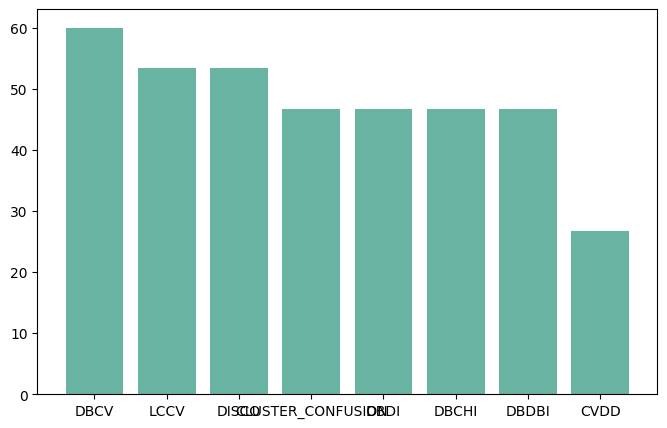

In [487]:
final_summary_table["% Consistent"] = (final_summary_table["N°Consistent"] / 15) * 100
final_summary_table["% Consistent"] = final_summary_table["% Consistent"].fillna(0)
plt.figure(figsize=(8, 5))
bars = plt.bar(final_summary_table["Metric"], final_summary_table["% Consistent"], color="#69b3a2")


/tmp/ipython-input-350096789.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(final_summary_table["Metric"], rotation=25, ha='right')


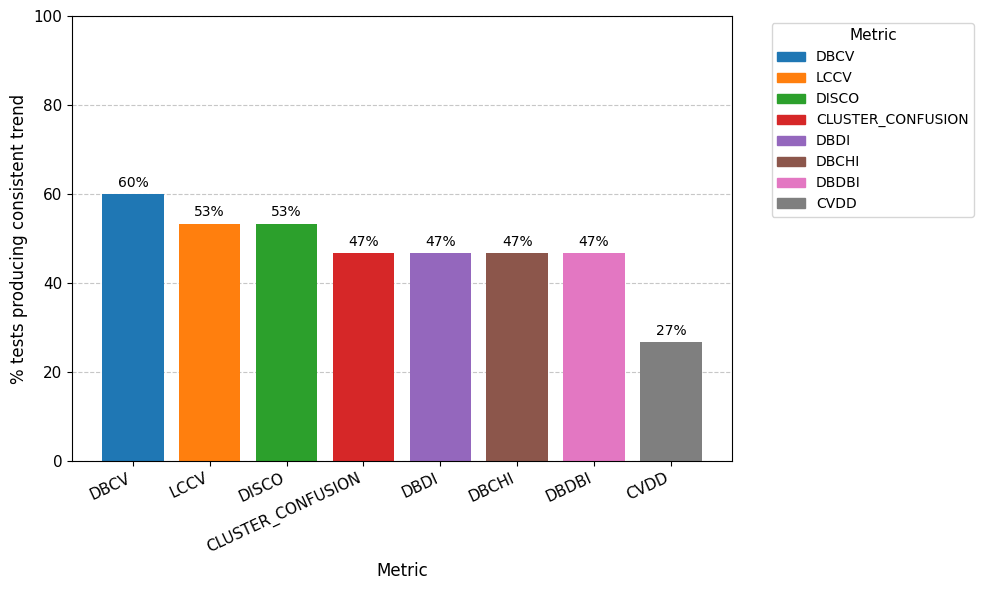

In [496]:
import matplotlib.pyplot as plt

colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728",  "#9467bd", "#8c564b", "#e377c2", "#7f7f7f" ]

fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(final_summary_table["Metric"], final_summary_table["% Consistent"], color=colors)


for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, height + 1, f"{height:.0f}%",
            ha='center', va='bottom', fontsize=10)


ax.set_axisbelow(True)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.xaxis.grid(False)

ax.set_ylabel("% tests producing consistent trend", fontsize=12)
ax.set_xlabel("Metric", fontsize=12)
ax.set_ylim(0, 100)
ax.tick_params(axis='both', labelsize=11)


ax.set_xticklabels(final_summary_table["Metric"], rotation=25, ha='right')

handles = [plt.Rectangle((0,0),1,1, color=color) for color in colors]
legend_labels = final_summary_table["Metric"]
ax.legend(handles, legend_labels, title="Metric",
          bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10, title_fontsize=11)

plt.tight_layout()
plt.savefig("consistencies.pdf", format="pdf", bbox_inches="tight")
plt.show()
